In [8]:
# here put the import lib
import copy
import os
import pickle
import numpy as np
from utils import read_jsonlines, multi_label_metric, ddi_rate_score, Voc, EHRTokenizer


# load diag, proc, med word2id tokenizer
voc_dir = "/home/wuyicong/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled/voc_final.pkl" #处理数据集的时候构建好的
ehr_tokenizer = EHRTokenizer(voc_dir)


def evaluate_jsonlines(data_path, ehr_tokenizer, threshold=0.5, med_num = "final",ddi_path='/home/wuyicong/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled', agent=True):
    experient_data = []
    for data_path_item in data_path:
        with open(data_path_item, "r", encoding="utf-8") as file:
            experient_data_item = json.load(file)
            experient_data += experient_data_item
            # experient_data = experient_data[1:] 
            
    #---------测试单次就诊和多次就诊的区别-------
    # single_visit = []
    # multi_visit = []
    # for item in experient_data:
    #     num = item["patient_condition"].split()[3]
    #     # print(num, type(num))
    #     if num == "0":
    #         single_visit.append(item)
    #     else:
    #         multi_visit.append(item)
    # experient_data = single_visit
    # # experient_data = multi_visit
    #-------------------
    print(len(experient_data))
       

    pred_data_prob, pred_data = [], []
    true_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    true_pred_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    seq_len = []
    pred_label = []

    def filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes):
        # 过滤掉不存在的 code
        valid_codes = [code for code in predict_atc_codes if code in ehr_tokenizer.med_voc.word2idx]
        # 将有效的 code 转换为 id
        valid_ids = ehr_tokenizer.convert_med_tokens_to_ids(valid_codes)
        return valid_ids




    for row, meta_data in enumerate(experient_data):
        
        if (not agent): #普通模型
            # noramlize the predicted scores by sigmoid, and get the prob
            meta_pred_data_prob = np.array(meta_data["target"])
            pred_data_prob.append(np_sigmoid(meta_pred_data_prob))
            
            # transform y to 0-1 by threshold
            meta_pred_data = copy.deepcopy(np_sigmoid(meta_pred_data_prob))
            meta_pred_data[meta_pred_data>=threshold] = 1
            meta_pred_data[meta_pred_data<threshold] = 0
            pred_data.append(meta_pred_data)
        else:
            # 预测结果中的 无序ATC3药物编码list 转为浮点数list
            # predict_atc_codes = meta_data["target_drug"]["target_drug_code"]# ground_truth
            predict_atc_codes = meta_data[f"{med_num}_medicine"]["atc3_code_list"]
            predict_atc_codes = [item[:4] for item in predict_atc_codes if len(item) >= 4]
            predict_atc_codes = list(set(predict_atc_codes)) #去重
            true_pred_index = filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes)
            true_pred_data[row][true_pred_index] = 1
            pred_data = true_pred_data
            # pred_data.append(true_pred_data)

        
        # get the true data #对每一个例子，存在使用的药物赋值为1(药物名称和索引的转换看这里)
        true_index = ehr_tokenizer.convert_med_tokens_to_ids(meta_data["target_drug"]["target_drug_code"])
        true_data[row][true_index] = 1

        #存储每条例子中病人访问医院的次数
        seq_len.append(int(meta_data["patient_condition"].split("The patient has ")[1].split(" times ICU visits.")[0]))

    # prepare the labels for DDI calculation
    if (not agent): #普通模型
        meta_label = np.where(meta_pred_data == 1)[0]
        pred_label.append([sorted(meta_label)])
    else:
        # print(true_pred_data)
        meta_label = [np.where(row == 1)[0].tolist() for row in true_pred_data]
        # meta_label = np.array([np.where(row == 1)[0] for row in true_pred_data])
        
        pred_label.append([sorted(sub_array) for sub_array in meta_label])

    #总的结果
    # print(true_data)
    # print("pred_data shape:", np.array(pred_data).shape, pred_data)
    # print("pred_data_prob shape:", np.array(pred_data_prob).shape)

    
    ja, avg_p, avg_r, avg_f1, mean, std = multi_label_metric(true_data, 
                                                         np.array(pred_data), 
                                                         np.array(pred_data_prob))
    ddi_adj = pickle.load(open(os.path.join(ddi_path, 'ddi_A_final.pkl'), 'rb'))
    ddi = ddi_rate_score(pred_label, ddi_adj)
    
    # print('\nJaccard: {:.4}, AVG_PRC: {:.4}, AVG_RECALL: {:.4}, AVG_F1: {:.4}, DDI_rate: {:.4}\n'.format(
    #       ja, avg_p, avg_r, avg_f1, ddi
    # ))
    # print("10-rounds Jaccard: %.5f + %.5f" % (mean[0], std[0]))
    # print("10-rounds F1-score: %.5f + %.5f" % (mean[1], std[1]))

    
    
    return ja, avg_p, avg_r, avg_f1, ddi
    # return ddi

    
def np_sigmoid(x):
    # sigmoid function using numpy
    return 1 / (1+np.exp(-x))




In [ ]:
import json

rag_pred_path = ["llm/Code-for-DDI/RAGents4DDI/output/2025-02-15-qwen_mimic3.json"]
# ja, avg_p, avg_r, avg_f1, ddi 
res_first = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "first")
res_final = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "second")

print("first:", res_first)
print("final:", res_final)

## 单因素方差分析------------

In [ ]:
#之前的ddi计算方法
# here put the import lib
import copy
import os
import pickle
import numpy as np
from utils import read_jsonlines, multi_label_metric_anova, ddi_rate_score_anova, Voc, EHRTokenizer, multi_test_anova

# load diag, proc, med word2id tokenizer
voc_dir = "/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled/voc_final.pkl" #处理数据集的时候构建好的
ehr_tokenizer = EHRTokenizer(voc_dir)


def evaluate_jsonlines_anova(data_path, ehr_tokenizer, threshold=0.5, med_num = "final",ddi_path='/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled', agent=True):
    experient_data = []
    for data_path_item in data_path:
        with open(data_path_item, "r", encoding="utf-8") as file:
            experient_data_item = json.load(file)
            experient_data += experient_data_item
            # experient_data = experient_data[:148] 
    print(len(experient_data))

    pred_data_prob, pred_data = [], []
    true_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    true_pred_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    seq_len = []
    pred_label = []

    def filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes):
        valid_codes = [code for code in predict_atc_codes if code in ehr_tokenizer.med_voc.word2idx]
        valid_ids = ehr_tokenizer.convert_med_tokens_to_ids(valid_codes)
        return valid_ids

    for row, meta_data in enumerate(experient_data):
        predict_atc_codes = meta_data["target_drug"]["target_drug_code"]# ground_truth
        predict_atc_codes = meta_data[f"{med_num}_medicine"]["atc3_code_list"]
        predict_atc_codes = [item[:4] for item in predict_atc_codes if len(item) >= 4]
        predict_atc_codes = list(set(predict_atc_codes)) #去重
        true_pred_index = filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes)
        true_pred_data[row][true_pred_index] = 1
        pred_data = true_pred_data
        true_index = ehr_tokenizer.convert_med_tokens_to_ids(meta_data["target_drug"]["target_drug_code"])
        true_data[row][true_index] = 1
        seq_len.append(int(meta_data["patient_condition"].split("The patient has ")[1].split(" times ICU visits.")[0]))
    meta_label = [np.where(row == 1)[0].tolist() for row in true_pred_data]
    pred_label.append([sorted(sub_array) for sub_array in meta_label])
    
    ja, p, r, f1, num = multi_label_metric_anova(true_data, 
                                                         np.array(pred_data), 
                                                         np.array(pred_data_prob))
    ddi_adj = pickle.load(open(os.path.join(ddi_path, 'ddi_A_final.pkl'), 'rb'))
    ddi_, ddi, ddi_avg, ddi_std = ddi_rate_score_anova(pred_label, ddi_adj)
    # print('======', pred_label)
    ja_avg, ja_std = multi_test_anova(ja)
    f1_avg, f1_std = multi_test_anova(f1)
    num_avg, num_std = multi_test_anova(num)
    # ddi_avg, ddi_std = multi_test_anova(ddi)
    res_avg_std = [ja_avg, ja_std, f1_avg, f1_std, ddi_avg, ddi_std, num_avg, num_std]
    
    return ja, f1, ddi, res_avg_std, num

In [ ]:
#计算ddi pairs的计算方法
# here put the import lib
import copy
import os
import pickle
import numpy as np
from utils import read_jsonlines, multi_label_metric_anova, Voc, EHRTokenizer, multi_test_anova, ddi_pairs, compute_ddi_rate_stats

# load diag, proc, med word2id tokenizer
voc_dir = "/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled/voc_final.pkl" #处理数据集的时候构建好的
ehr_tokenizer = EHRTokenizer(voc_dir)


def evaluate_jsonlines_anova(data_path, ehr_tokenizer, threshold=0.5, med_num = "final",ddi_path='/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled', agent=True):
    experient_data = []
    for data_path_item in data_path:
        with open(data_path_item, "r", encoding="utf-8") as file:
            experient_data_item = json.load(file)
            experient_data += experient_data_item
            # experient_data = experient_data[:50] 
    print(len(experient_data))

    pred_data_prob, pred_data = [], []
    true_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    true_pred_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    seq_len = []
    pred_label = []

    def filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes):
        valid_codes = [code for code in predict_atc_codes if code in ehr_tokenizer.med_voc.word2idx]
        valid_ids = ehr_tokenizer.convert_med_tokens_to_ids(valid_codes)
        return valid_ids

    for row, meta_data in enumerate(experient_data):
        predict_atc_codes = meta_data["target_drug"]["target_drug_code"]# ground_truth
        predict_atc_codes = meta_data[f"{med_num}_medicine"]["atc3_code_list"]
        predict_atc_codes = [item[:4] for item in predict_atc_codes if len(item) >= 4]
        predict_atc_codes = list(set(predict_atc_codes)) #去重
        true_pred_index = filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes)
        true_pred_data[row][true_pred_index] = 1
        pred_data = true_pred_data
        true_index = ehr_tokenizer.convert_med_tokens_to_ids(meta_data["target_drug"]["target_drug_code"])
        true_data[row][true_index] = 1
        seq_len.append(int(meta_data["patient_condition"].split("The patient has ")[1].split(" times ICU visits.")[0]))
    meta_label = [np.where(row == 1)[0].tolist() for row in true_pred_data]
    pred_label.append([sorted(sub_array) for sub_array in meta_label])
    
    ja, p, r, f1, num = multi_label_metric_anova(true_data, 
                                                         np.array(pred_data), 
                                                         np.array(pred_data_prob))
    ddi_adj = pickle.load(open(os.path.join(ddi_path, 'ddi_A_final.pkl'), 'rb'))
    ddi_pair, all_pair = ddi_pairs(pred_label, ddi_adj)
    ddi_rates, mean_ddi_rate, std_ddi_rate = compute_ddi_rate_stats(ddi_pair, all_pair)
    # print('======', ddi_pair, all_pair, pred_label)
    ja_avg, ja_std = multi_test_anova(ja)
    f1_avg, f1_std = multi_test_anova(f1)
    num_avg, num_std = multi_test_anova(num)
    # ddi_avg, ddi_std = multi_test_anova(ddi_p)
    # res_avg_std = [ja_avg, ja_std, f1_avg, f1_std, ddi_avg, ddi_std, num_avg, num_std]
    res_avg_std = [ja_avg, ja_std, f1_avg, f1_std, mean_ddi_rate, std_ddi_rate, num_avg, num_std]
    
    return ja, f1, res_avg_std, num

In [ ]:
import json

rag_pred_path = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_deepseek_all_node2_rag_mimic3.json"]

res_first = evaluate_jsonlines_anova(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "first")
res_final = evaluate_jsonlines_anova(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "second")

# print("pure:", pure_res_final)
# print("first:", res_first)
# # print("second_round:", res_second)
# print("final:", res_final)
sample_len = len(res_first[0])
show_pure_qwen = [f"{num:.4f}" for num in res_first[3]]  # 保留 4 位小数
formatted_result = [f"{show_pure_qwen[i]} ± {show_pure_qwen[i+1]}" for i in range(0, len(show_pure_qwen), 2)]
second = [f"{num:.4f}" for num in res_final[3]]  # 保留 4 位小数
second_res = [f"{second[i]} ± {second[i+1]}" for i in range(0, len(second), 2)]
print(formatted_result)
print(second_res)

In [35]:
import numpy as np
from scipy.stats import t

def independent_ttest(mean1, sd1, n1, mean2, sd2, n2):
    # 计算t值
    se = np.sqrt((sd1**2 / n1) + (sd2**2 / n2))  # 标准误
    t_value = (mean1 - mean2) / se
    
    # 计算自由度（Welch校正）
    df_numerator = ((sd1**2 / n1) + (sd2**2 / n2))**2
    df_denominator = (sd1**4 / (n1**2 * (n1 - 1))) + (sd2**4 / (n2**2 * (n2 - 1)))
    df = df_numerator / df_denominator
    
    # 计算双尾p值
    p_value = 2 * t.sf(np.abs(t_value), df)
    return t_value, df, p_value

# 示例数据
mean2, sd2, n2 = 0.0672, 0.0010, 10  # 组1：均值、标准差、样本量
mean1, sd1, n1 = 0.0703, 0.0010, 10    # 组2

t_value, df, p_value = independent_ttest(mean1, sd1, n1, mean2, sd2, n2)
print(f"t({df:.2f}) = {t_value:.3f}, p = {p_value:.4f}")

t(18.00) = 6.932, p = 0.0000


In [36]:
# 计算Cohen's d（效应量）
pooled_sd = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))
cohens_d = (mean1 - mean2) / pooled_sd
print(f"Cohen's d = {cohens_d:.2f}")

Cohen's d = 3.10


In [44]:

import json
rag_pred_path_qwen = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_qwen_all_node2_rag_mimic3.json"]
pure_pred_path_qwen = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_qwen_all_pure_mimic3.json"]
rag_pred_path_ds = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_deepseek_all_node2_rag_mimic3.json"]
pure_pred_path_ds = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_2025-02-28-ds_pure_top_30_mimic3.json"]
rag_pred_path_mistral = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_mistral_all_node2_rag_mimic3.json"]
pure_pred_path_mistral = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_mistral_all_pure_mimic3.json"]
rag_pred_path_gpt = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_gpt_all_node2_rag_mimic3.json"]
pure_pred_path_gpt = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_gpt_pure_rag_mimic3.json"]

no_rag_pred_path_qwen = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_qwen_all_withoutrag_mimic3.json"]

# ja, avg_p, avg_r, avg_f1, ddi 
# ja, f1, ddi, res_avg_std 
# print(res_first[3])
pure_qwen = evaluate_jsonlines_anova(pure_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "final")
initial_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "first")
revised_single_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "single_discussed")
revised_multi_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "multi_discussed")
revised_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "second")
voted_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "final")
control_single_revised_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "fixed_single_second")
control_single_voted_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "fixed_single_final")
control_multi_revised_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "fixed_multi_second")
control_multi_voted_qwen = evaluate_jsonlines_anova(rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "fixed_multi_final")


pure_ds = evaluate_jsonlines_anova(pure_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "final")
initial_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "first")
revised_single_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "single_discussed")
revised_multi_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "multi_discussed")
revised_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "second")
voted_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "final")
control_single_revised_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "fixed_single_second")
control_single_voted_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "fixed_single_final")
control_multi_revised_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "fixed_multi_second")
control_multi_voted_ds = evaluate_jsonlines_anova(rag_pred_path_ds, ehr_tokenizer, threshold=0.5, med_num = "fixed_multi_final")


pure_mistral = evaluate_jsonlines_anova(pure_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "final")
initial_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "first")
revised_single_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "single_discussed")
revised_multi_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "multi_discussed")
revised_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "second")
voted_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "final")
control_single_revised_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "fixed_single_second")
control_single_voted_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "fixed_single_final")
control_multi_revised_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "fixed_multi_second")
control_multi_voted_mistral = evaluate_jsonlines_anova(rag_pred_path_mistral, ehr_tokenizer, threshold=0.5, med_num = "fixed_multi_final")

pure_gpt = evaluate_jsonlines_anova(pure_pred_path_gpt, ehr_tokenizer, threshold=0.5, med_num = "final")
initial_gpt = evaluate_jsonlines_anova(rag_pred_path_gpt, ehr_tokenizer, threshold=0.5, med_num = "first")
revised_gpt = evaluate_jsonlines_anova(rag_pred_path_gpt, ehr_tokenizer, threshold=0.5, med_num = "second")
voted_gpt = evaluate_jsonlines_anova(rag_pred_path_gpt, ehr_tokenizer, threshold=0.5, med_num = "final")

initial_no_rag_qwen = evaluate_jsonlines_anova(no_rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "first")
revised_no_rag_qwen = evaluate_jsonlines_anova(no_rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "second")
voted_no_rag_qwen = evaluate_jsonlines_anova(no_rag_pred_path_qwen, ehr_tokenizer, threshold=0.5, med_num = "final")

sample_len = len(initial_qwen[0])



10
10


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


In [45]:
#多个模型之间的显著性差异分析
import scipy.stats as stats
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.lines import Line2D  # 用于创建自定义图例

# 假设有多个基座模型，每个基座模型有不同的实验组
base_models = [
    "qwen", 
    "ds", 
    "mistral",
    "gpt"
    ]  # 基座模型列表
# base_models = [
#     "qwen", 
#     "no_rag_qwen"
#     ]  
# groups = ["revised", "control_single_revised", "control_multi_revised"]  # 组别
groups = ["pure", "initial", "revised","voted"]
groups = ["pure", "initial", "revised"]
# groups = ["pure", "initial", "control_single_revised","control_single_voted"]
# groups = ["initial", "revised","voted"]
data = {
    'Model': [],  # 记录模型名称
    'Group': [],  # 记录实验组
    'ja': [],  # ja 数据
    'f1': [],  # avg_f1 数据
    # 'ddi': []  # ddi 数据
    'num': [], #number of drugs
}

data_ddi = {
    'Model': [],
    'Group': [],  # 按组名填充
    'ddi': [],  # ddi 数据
    
}

# 假设每个模型的不同组的数据是预定义的，可以替换成你的实际数据
for model in base_models:
    for group in groups:
        # 这里的 eval 需要替换成实际的数据来源
        ja_values = eval(f"{group}_{model}")[0]  # ja 数据
        f1_values = eval(f"{group}_{model}")[1]  # avg_f1 数据
        # ddi_values = eval(f"{group}_{model}")[2]  # ddi 数据
        num_values = eval(f"{group}_{model}")[4]
        
        data['Model'].extend([model] * len(ja_values))
        data['Group'].extend([group] * len(ja_values))
        data['ja'].extend(ja_values)
        data['f1'].extend(f1_values)
        data['num'].extend(num_values)
        # data['ddi'].extend(ddi_values)

for model in base_models:
    for group in groups:
        ddi_values = eval(f"{group}_{model}")[2]  # ddi 数据
        
        data_ddi['Model'].extend([model] * len(ddi_values))
        data_ddi['Group'].extend([group] * len(ddi_values))
        data_ddi['ddi'].extend(ddi_values)
        

# 创建 DataFrame
df = pd.DataFrame(data)
df_ddi = pd.DataFrame(data_ddi)

In [52]:
# 导出为Excel文件
df_ddi.to_excel('ddi_data.xlsx', index=False)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd  # 事后检验
data_df = df ######
# 定义显著性符号标记（使用更严格的标准）
def get_significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# 定义p值格式化函数
def format_p_value(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.01:
        return f"{p:.3f}"
    else:
        return f"{p:.3f}"

# 函数来执行ANOVA和Tukey检验
def perform_anova_and_tukey(group_data, metric):
    models = group_data['Model'].unique()
    if len(models) < 2:
        return None, None  # 如果组数少于2，返回None
    
    # 单因素方差分析
    anova_data = [group_data[group_data['Model'] == model][metric] for model in models]
    _, anova_p = f_oneway(*anova_data)

    tukey_result = None
    if anova_p < 0.05:
        tukey = pairwise_tukeyhsd(
            endog=group_data[metric],
            groups=group_data['Model'],
            alpha=0.05
        )
        tukey_result = tukey._results_table.data[1:]  # 排除表头

    return anova_p, tukey_result

# 主处理部分
significance_results = []
summary_stats = []

for metric in ['num']:  # 目前只考虑'ja'，可以拓展#######
    for group in data_df['Group'].unique():
        group_data = data_df[data_df['Group'] == group]
        
        # 执行ANOVA和Tukey检验
        anova_p, tukey_result = perform_anova_and_tukey(group_data, metric)
        
        # 记录ANOVA和Tukey检验结果
        if tukey_result:
            for row in tukey_result:
                model1, model2, _, _, _, _, p_value = row
                significance_results.append({
                    'Metric': metric,
                    'Group': group,
                    'Model1': model1,
                    'Model2': model2,
                    'p_value': p_value,
                    'anova_p': anova_p
                })
        else:
            models = group_data['Model'].unique()
            for model1 in models:
                for model2 in models:
                    if model1 != model2:
                        significance_results.append({
                            'Metric': metric,
                            'Group': group,
                            'Model1': model1,
                            'Model2': model2,
                            'p_value': False,
                            'anova_p': 0.05
                        })
        
        # 计算每组的均值和标准误差
        for model in group_data['Model'].unique():
            model_data = group_data[group_data['Model'] == model]
            mean_value = model_data[metric].mean()
            sem_value = model_data[metric].sem()
            summary_stats.append({
                'Group': group,
                'Model': model,
                'Mean': mean_value,
                'SEM': sem_value
            })

# 将显著性检验结果转换为 DataFrame
significance_df = pd.DataFrame(significance_results)
significance_df['significance'] = significance_df['anova_p'].apply(get_significance_stars)

# 将每组的统计信息转换为 DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# 创建完整结果表格
full_results = significance_df.copy()
full_results['ANOVA p'] = full_results['anova_p'].apply(format_p_value)
full_results['Post-hoc p'] = full_results['p_value'].apply(format_p_value)
full_results['Comparison'] = full_results['Model1'] + ' vs ' + full_results['Model2']

# 打印格式化表格
print("显著性检验结果汇总：\n")
print(full_results[['Group', 'Comparison', 'ANOVA p', 'Post-hoc p', 'significance']]
      .rename(columns={'significance': 'Sig.'})
      .to_string(index=False, justify='center'))

# 打印每组的统计数据（均值和标准误差）
print("\n每组的统计数据：\n")
print(summary_stats_df[['Group', 'Model', 'Mean', 'SEM']].to_string(index=False, justify='center'))


显著性检验结果汇总：

 Group     Comparison   ANOVA p Post-hoc p Sig.
   pure       ds vs gpt  <0.001   <0.001   *** 
   pure   ds vs mistral  <0.001    1.000   *** 
   pure      ds vs qwen  <0.001    1.000   *** 
   pure  gpt vs mistral  <0.001    1.000   *** 
   pure     gpt vs qwen  <0.001    1.000   *** 
   pure mistral vs qwen  <0.001    1.000   *** 
initial       ds vs gpt  <0.001    1.000   *** 
initial   ds vs mistral  <0.001    1.000   *** 
initial      ds vs qwen  <0.001   <0.001   *** 
initial  gpt vs mistral  <0.001    1.000   *** 
initial     gpt vs qwen  <0.001    1.000   *** 
initial mistral vs qwen  <0.001    1.000   *** 
revised       ds vs gpt  <0.001    1.000   *** 
revised   ds vs mistral  <0.001    1.000   *** 
revised      ds vs qwen  <0.001   <0.001   *** 
revised  gpt vs mistral  <0.001    1.000   *** 
revised     gpt vs qwen  <0.001    1.000   *** 
revised mistral vs qwen  <0.001    1.000   *** 

每组的统计数据：

 Group   Model     Mean      SEM  
   pure    qwen 16.980477 0.31

In [ ]:
# 组内
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 定义显著性符号标记函数
def get_significance_stars(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'

# 定义p值格式化函数
def format_p_value(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

# 执行ANOVA和Tukey检验的函数
def perform_anova_and_tukey(group_data, metric):
    # 提取当前模型下的所有实验组（如pure/initial/revised）
    groups = group_data['Group'].unique()
    if len(groups) < 2:
        return None, None
    
    # 单因素方差分析
    anova_data = [group_data[group_data['Group'] == grp][metric] for grp in groups]
    _, anova_p = f_oneway(*anova_data)
    
    # Tukey HSD事后检验
    tukey_result = None
    if anova_p < 0.05:
        tukey = pairwise_tukeyhsd(
            endog=group_data[metric],
            groups=group_data['Group'],
            alpha=0.05
        )
        tukey_result = tukey._results_table.data[1:]
    
    return anova_p, tukey_result

# 主分析流程（以ds模型为例）
target_model = "mistral"  # 指定要分析的基座模型
metrics = ['ddi']    # 要分析的指标列表

significance_results = []
summary_stats = []

# 提取目标模型的数据
model_data = df_ddi[df_ddi['Model'] == target_model]

for metric in metrics:
    anova_p, tukey_result = perform_anova_and_tukey(model_data, metric)
    
    # 记录ANOVA和Tukey结果
    if tukey_result:
        for row in tukey_result:
            group1, group2, _, _, _, _, p_value = row
            significance_results.append({
                'Metric': metric,
                'Model': target_model,
                'Group1': group1,
                'Group2': group2,
                'p_value': p_value,
                'anova_p': anova_p
            })
    else:
        groups = model_data['Group'].unique()
        for group1 in groups:
            for group2 in groups:
                if group1 != group2:
                    significance_results.append({
                        'Metric': metric,
                        'Model': target_model,
                        'Group1': group1,
                        'Group2': group2,
                        'p_value': np.nan,
                        'anova_p': anova_p
                    })
    
    # 计算每个实验组的统计量
    for group in model_data['Group'].unique():
        group_subset = model_data[model_data['Group'] == group]
        mean_val = group_subset[metric].mean()
        sem_val = group_subset[metric].sem()
        summary_stats.append({
            'Model': target_model,
            'Group': group,
            'Mean': mean_val,
            'SEM': sem_val
        })

# 生成结果表格
significance_df = pd.DataFrame(significance_results)
significance_df['significance'] = significance_df['p_value'].apply(
    lambda x: get_significance_stars(x) if not np.isnan(x) else 'ns'
)

summary_stats_df = pd.DataFrame(summary_stats)

# 打印结果
print(f"{target_model} 组内实验组间显著性检验：\n")
print(significance_df[['Group1', 'Group2', 'p_value', 'significance']]
      .rename(columns={'p_value': 'p-value', 'significance': 'Sig.'})
      .to_string(index=False, justify='center'))

print(f"\n{target_model} 各组统计数据：\n")
print(summary_stats_df[['Group', 'Mean', 'SEM']].to_string(index=False, justify='center'))

mistral 组内实验组间显著性检验：

 Group1  Group2  p-value Sig.
initial    pure   True    ns 
initial revised   True    ns 
   pure revised   True    ns 

mistral 各组统计数据：

 Group    Mean      SEM  
   pure 0.080312 0.000371
initial 0.067486 0.000135
revised 0.051337 0.000116


In [ ]:
# 组内
from scipy.stats import ttest_ind, ttest_rel  # 独立/配对t检验

def compare_groups(group_data, metric, group1, group2, paired=False):
    """比较两组差异（支持独立样本或配对t检验）"""
    data1 = group_data[group_data['Group'] == group1][metric]
    data2 = group_data[group_data['Group'] == group2][metric]
    
    if paired:  # 如果是配对数据（如同一患者不同阶段）
        print("配对")
        if len(data1) == len(data2):
            t_stat, p_value = ttest_rel(data1, data2)
        else:
            raise ValueError("配对数据长度不一致！")
    else:       # 独立样本
        t_stat, p_value = ttest_ind(data1, data2, equal_var=False)  # Welch's t-test
    
    return p_value

# 示例：比较ds模型下initial和revised组的差异（独立样本）
p_value = compare_groups(model_data, 'ddi', 'initial', 'revised', paired=False)
# p_value = compare_groups(model_data, 'ddi', 'pure', 'initial', paired=False)
print(f"pure vs initial p-value: {format_p_value(p_value)} {get_significance_stars(p_value)}")

pure vs initial p-value: <0.001 ***


In [33]:
import pandas as pd
import re

# 你的文本数据 --ddi, f1, ja, num
text_data = """
显著性检验结果汇总：

 Group     Comparison   ANOVA p Post-hoc p Sig.
   pure       ds vs gpt  <0.001   <0.001   *** 
   pure   ds vs mistral  <0.001    1.000   *** 
   pure      ds vs qwen  <0.001    1.000   *** 
   pure  gpt vs mistral  <0.001    1.000   *** 
   pure     gpt vs qwen  <0.001    1.000   *** 
   pure mistral vs qwen  <0.001    1.000   *** 
initial       ds vs gpt  <0.001    1.000   *** 
initial   ds vs mistral  <0.001    1.000   *** 
initial      ds vs qwen  <0.001    1.000   *** 
initial  gpt vs mistral  <0.001    1.000   *** 
initial     gpt vs qwen  <0.001    1.000   *** 
initial mistral vs qwen  <0.001    1.000   *** 
revised       ds vs gpt  <0.001    1.000   *** 
revised   ds vs mistral  <0.001    1.000   *** 
revised      ds vs qwen  <0.001   <0.001   *** 
revised  gpt vs mistral  <0.001    1.000   *** 
revised     gpt vs qwen  <0.001    1.000   *** 
revised mistral vs qwen  <0.001    1.000   *** 

每组的统计数据：

 Group   Model    Mean      SEM  
   pure    qwen 0.090989 0.000307
   pure      ds 0.098899 0.000539
   pure mistral 0.079421 0.000318
   pure     gpt 0.098060 0.000447
initial    qwen 0.085601 0.000260
initial      ds 0.091111 0.000232
initial mistral 0.067471 0.000109
initial     gpt 0.097292 0.000285
revised    qwen 0.068524 0.000290
revised      ds 0.067763 0.000329
revised mistral 0.051709 0.000100
revised     gpt 0.074616 0.000251
"""

text_data = '''
显著性检验结果汇总：

 Group     Comparison   ANOVA p Post-hoc p Sig.
   pure       ds vs gpt  <0.001   <0.001   *** 
   pure   ds vs mistral  <0.001   <0.001   *** 
   pure      ds vs qwen  <0.001    1.000   *** 
   pure  gpt vs mistral  <0.001   <0.001   *** 
   pure     gpt vs qwen  <0.001    1.000   *** 
   pure mistral vs qwen  <0.001    1.000   *** 
initial       ds vs gpt  <0.001   <0.001   *** 
initial   ds vs mistral  <0.001    1.000   *** 
initial      ds vs qwen  <0.001   <0.001   *** 
initial  gpt vs mistral  <0.001    1.000   *** 
initial     gpt vs qwen  <0.001   <0.001   *** 
initial mistral vs qwen  <0.001    1.000   *** 
revised       ds vs gpt  <0.001   <0.001   *** 
revised   ds vs mistral  <0.001    1.000   *** 
revised      ds vs qwen  <0.001   <0.001   *** 
revised  gpt vs mistral  <0.001    1.000   *** 
revised     gpt vs qwen  <0.001   <0.001   *** 
revised mistral vs qwen  <0.001    1.000   *** 

每组的统计数据：

 Group   Model    Mean      SEM  
   pure    qwen 0.550212 0.007637
   pure      ds 0.509763 0.007618
   pure mistral 0.497132 0.008129
   pure     gpt 0.483526 0.007899
initial    qwen 0.587088 0.006226
initial      ds 0.581195 0.006466
initial mistral 0.457127 0.005873
initial     gpt 0.575304 0.007060
revised    qwen 0.529129 0.006346
revised      ds 0.525161 0.005895
revised mistral 0.415440 0.005545
revised     gpt 0.511020 0.006674
'''

text_data = '''
显著性检验结果汇总：

 Group     Comparison   ANOVA p Post-hoc p Sig.
   pure       ds vs gpt  <0.001   <0.001   *** 
   pure   ds vs mistral  <0.001   <0.001   *** 
   pure      ds vs qwen  <0.001    1.000   *** 
   pure  gpt vs mistral  <0.001   <0.001   *** 
   pure     gpt vs qwen  <0.001    1.000   *** 
   pure mistral vs qwen  <0.001    1.000   *** 
initial       ds vs gpt  <0.001   <0.001   *** 
initial   ds vs mistral  <0.001    1.000   *** 
initial      ds vs qwen  <0.001   <0.001   *** 
initial  gpt vs mistral  <0.001    1.000   *** 
initial     gpt vs qwen  <0.001   <0.001   *** 
initial mistral vs qwen  <0.001    1.000   *** 
revised       ds vs gpt  <0.001   <0.001   *** 
revised   ds vs mistral  <0.001    1.000   *** 
revised      ds vs qwen  <0.001   <0.001   *** 
revised  gpt vs mistral  <0.001    1.000   *** 
revised     gpt vs qwen  <0.001   <0.001   *** 
revised mistral vs qwen  <0.001    1.000   *** 

每组的统计数据：

 Group   Model    Mean      SEM  
   pure    qwen 0.396202 0.006951
   pure      ds 0.357437 0.006618
   pure mistral 0.348064 0.007015
   pure     gpt 0.335238 0.006906
initial    qwen 0.427776 0.006088
initial      ds 0.421977 0.005963
initial mistral 0.305076 0.005055
initial     gpt 0.418584 0.006561
revised    qwen 0.370902 0.005669
revised      ds 0.365635 0.005233
revised mistral 0.269404 0.004512
revised     gpt 0.354969 0.005756
'''

# text_data = '''
# 显著性检验结果汇总：

#  Group     Comparison   ANOVA p Post-hoc p Sig.
#    pure       ds vs gpt  <0.001   <0.001   *** 
#    pure   ds vs mistral  <0.001    1.000   *** 
#    pure      ds vs qwen  <0.001    1.000   *** 
#    pure  gpt vs mistral  <0.001    1.000   *** 
#    pure     gpt vs qwen  <0.001    1.000   *** 
#    pure mistral vs qwen  <0.001    1.000   *** 
# initial       ds vs gpt  <0.001    1.000   *** 
# initial   ds vs mistral  <0.001    1.000   *** 
# initial      ds vs qwen  <0.001   <0.001   *** 
# initial  gpt vs mistral  <0.001    1.000   *** 
# initial     gpt vs qwen  <0.001    1.000   *** 
# initial mistral vs qwen  <0.001    1.000   *** 
# revised       ds vs gpt  <0.001    1.000   *** 
# revised   ds vs mistral  <0.001    1.000   *** 
# revised      ds vs qwen  <0.001   <0.001   *** 
# revised  gpt vs mistral  <0.001    1.000   *** 
# revised     gpt vs qwen  <0.001    1.000   *** 
# revised mistral vs qwen  <0.001    1.000   *** 

# 每组的统计数据：

#  Group   Model     Mean      SEM  
#    pure    qwen 16.980477 0.314124
#    pure      ds 13.718004 0.284642
#    pure mistral 19.540130 0.507431
#    pure     gpt 12.527115 0.246745
# initial    qwen 26.125813 0.459029
# initial      ds 25.062907 0.436386
# initial mistral 56.934924 1.115076
# initial     gpt 21.171367 0.329443
# revised    qwen 22.971800 0.423117
# revised      ds 21.973970 0.387022
# revised mistral 47.329718 0.970463
# revised     gpt 18.800434 0.306209
# '''

#RAG
# text_data = '''
# 显著性检验结果汇总：

#  Group       Comparison     ANOVA p Post-hoc p Sig.
# initial qwen vs no_rag_qwen   0.050   <0.001    ns 
# initial no_rag_qwen vs qwen   0.050   <0.001    ns 
# revised no_rag_qwen vs qwen  <0.001    1.000   *** 
#   voted no_rag_qwen vs qwen  <0.001    1.000   *** 

# 每组的统计数据：

#  Group     Model      Mean      SEM  
# initial        qwen 0.086059 0.000353
# initial no_rag_qwen 0.085972 0.000413
# revised        qwen 0.068375 0.000190
# revised no_rag_qwen 0.081087 0.000250
#   voted        qwen 0.070069 0.000189
#   voted no_rag_qwen 0.083788 0.000376
# '''

# 1. 解析显著性检验结果
sig_results = []
sig_section = re.search(r"显著性检验结果汇总：\n\n(.+?)\n\n每组的统计数据：", text_data, re.DOTALL)
if sig_section:
    sig_lines = sig_section.group(1).strip().split("\n")[1:]  # 跳过表头
    for line in sig_lines:
        parts = re.split(r'\s+', line.strip())  # 按空格拆分
        sig_results.append({
            'Group': parts[0],
            'Comparison': f"{parts[1]} {parts[2]} {parts[3]}",  # 组合出 "ds vs qwen"
            'ANOVA p': parts[4],
            'Post-hoc p': parts[5],
            'Sig.': parts[6]
        })

# 转换为 DataFrame
significance_df = pd.DataFrame(sig_results)

# 2. 解析统计数据
summary_results = []
stats_section = re.search(r"每组的统计数据：\n\n(.+)", text_data, re.DOTALL)
if stats_section:
    stats_lines = stats_section.group(1).strip().split("\n")[1:]  # 跳过表头
    for line in stats_lines:
        parts = re.split(r'\s+', line.strip())  # 按空格拆分
        summary_results.append({
            'Group': parts[0],
            'Model': parts[1],
            'Mean': float(parts[2]),
            'SEM': float(parts[3])
        })

# 转换为 DataFrame
summary_stats_df = pd.DataFrame(summary_results)

# 打印结果
print("显著性检验结果 DataFrame：")
print(significance_df)
print("\n统计数据 DataFrame：")
print(summary_stats_df)


显著性检验结果 DataFrame：
      Group       Comparison ANOVA p Post-hoc p Sig.
0      pure        ds vs gpt  <0.001     <0.001  ***
1      pure    ds vs mistral  <0.001     <0.001  ***
2      pure       ds vs qwen  <0.001      1.000  ***
3      pure   gpt vs mistral  <0.001     <0.001  ***
4      pure      gpt vs qwen  <0.001      1.000  ***
5      pure  mistral vs qwen  <0.001      1.000  ***
6   initial        ds vs gpt  <0.001     <0.001  ***
7   initial    ds vs mistral  <0.001      1.000  ***
8   initial       ds vs qwen  <0.001     <0.001  ***
9   initial   gpt vs mistral  <0.001      1.000  ***
10  initial      gpt vs qwen  <0.001     <0.001  ***
11  initial  mistral vs qwen  <0.001      1.000  ***
12  revised        ds vs gpt  <0.001     <0.001  ***
13  revised    ds vs mistral  <0.001      1.000  ***
14  revised       ds vs qwen  <0.001     <0.001  ***
15  revised   gpt vs mistral  <0.001      1.000  ***
16  revised      gpt vs qwen  <0.001     <0.001  ***
17  revised  mistral vs qwe

In [ ]:
#柱状图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 设置颜色和样式
palette = ["#A5D180", "#F7C9CF", "#ADD3F4", "#F5E6C8"]
model_order = ['qwen', 'ds', 'mistral', 'gpt']
model_labels = ["Qwen", "DeepSeek", "Mistral", "ChatGPT"]
group_names = summary_stats_df['Group'].unique()
group_positions = np.arange(len(group_names))

# 柱状图布局参数
bar_width = 0.2
model_offsets = [-0.3, -0.1, 0.1, 0.3]

plt.figure(figsize=(12, 8))

# 绘制柱状图
for group_idx, group in enumerate(group_names):
    for model_idx, model in enumerate(model_order):
        data = summary_stats_df[(summary_stats_df['Group'] == group) & 
                               (summary_stats_df['Model'] == model)]
        if not data.empty:
            mean = data['Mean'].values[0]
            sem = data['SEM'].values[0]
            x = group_positions[group_idx] + model_offsets[model_idx]
            
            # 绘制柱子和误差线
            plt.bar(x, mean, width=bar_width, color=palette[model_idx], 
                   edgecolor='grey', zorder=2)
            plt.errorbar(x, mean, yerr=sem, fmt='none', ecolor='black',
                        capsize=5, capthick=1, elinewidth=1.5, zorder=3)

# 处理显著性标记
y_offset = 0.003  # 根据数据范围调整
text_gap = 0.002

for _, row in significance_df.iterrows():
    # 转换posthoc p值为数值
    posthoc_p = row['Sig.']
    if posthoc_p.startswith('<'):
        p_value = float(posthoc_p[1:])
    else:
        # p_value = float(posthoc_p)
        p_value = 0.01
    
    if p_value < 0.05:  # 仅标注显著结果
        group = row['Group']
        model1, model2 = row['Comparison'].split(' vs ')
        
        try:
            # 获取模型索引
            m1_idx = model_order.index(model1)
            m2_idx = model_order.index(model2)
            group_idx = list(group_names).index(group)
        except ValueError:
            continue
        
        # 计算柱子的x坐标
        x1 = group_positions[group_idx] + model_offsets[m1_idx]
        x2 = group_positions[group_idx] + model_offsets[m2_idx]
        
        # 获取对应y值
        y1 = summary_stats_df[(summary_stats_df['Group'] == group) & 
                             (summary_stats_df['Model'] == model1)]['Mean'].values[0]
        y2 = summary_stats_df[(summary_stats_df['Group'] == group) & 
                             (summary_stats_df['Model'] == model2)]['Mean'].values[0]
        y_max = max(y1, y2)
        
        # 绘制显著性标记
        plt.plot([x1, x1, x2, x2], 
                [y_max + y_offset, y_max + y_offset*2, y_max + y_offset*2, y_max + y_offset],
                color='black', lw=1)
        plt.text((x1+x2)/2, y_max + y_offset*2 + text_gap, row['Sig.'], 
                ha='center', va='bottom', fontsize=14)

# 坐标轴设置
plt.xticks(group_positions, group_names, fontsize=18)
plt.xlabel("Process node", fontsize=18)
plt.ylabel("ddi", fontsize=18)
plt.ylim(top=plt.ylim()[1]*1.1)  # 留出标注空间

# 添加图例
legend_elements = [Line2D([0], [0], color=palette[i], lw=4, label=model_labels[i]) 
                  for i in range(4)]
plt.legend(handles=legend_elements, loc='upper right', 
          bbox_to_anchor=(0.95, 0.95), fontsize=14)

# 美化设置
sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

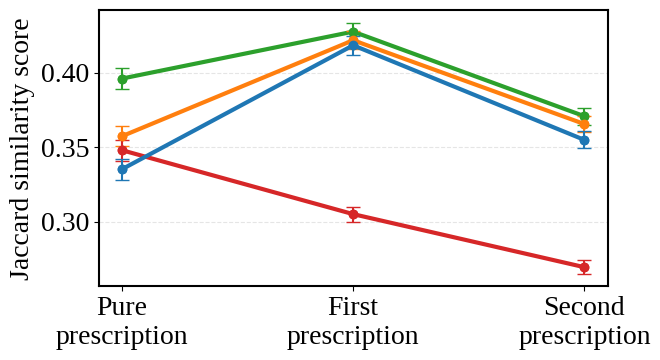

In [34]:
#折线图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import rcParams  # 导入全局字体设置模块

# === 1. 全局设置Times New Roman字体 ===
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Liberation Serif', 'DejaVu Serif', 'Nimbus Roman', 'STIXGeneral'] 
rcParams['font.size'] = 20  

# 颜色映射
palette = sns.color_palette("Set2")
palette = ["#A5D180", "#F7C9CF", "#ADD3F4", "#F5E6C8"]
palette = ["#2ca02c", "#ff7f0e", "#d62728", "#1f77b4"]
model_colors = {
    "GPT-4o": "#1f77b4",  # 蓝色
    "DeepSeek-V3": "#ff7f0e",  # 橙色
    "Qwen2.5": "#2ca02c",  # 绿色
    "Mistral": "#d62728"  # 红色
}

# 创建画布
plt.figure(figsize=(7, 4))
# 关键设置：强制规定边距（left, bottom, right, top）
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.9, top=0.9)  # 单位是比例值

# 遍历不同模型，绘制折线 + 误差线
for i, model in enumerate(summary_stats_df['Model'].unique()):
    model_data = summary_stats_df[summary_stats_df['Model'] == model]
    plt.plot(model_data['Group'], model_data['Mean'], marker='o', label=model, color=palette[i], linewidth=3)
    plt.errorbar(model_data['Group'], model_data['Mean'], yerr=model_data['SEM'], fmt='o', 
                 color=palette[i], capsize=5, capthick=1, elinewidth=1.5)  # 误差线增加短横线

# 处理显著性标记
y_offset = 0.015  # 星号与横线的垂直偏移量
line_height = 0.005  # 横线的高度
# 获取 Group 的唯一值作为 x 轴的位置
group_positions = list(summary_stats_df['Group'].unique())

# for _, row in significance_df.iterrows():
#     if row['Sig.'] != 'ns':  # 仅标记显著性结果
#         x1, x2 = group_positions.index(row['Group']), group_positions.index(row['Group'])  # 获取索引位置
#         y_max = summary_stats_df[summary_stats_df['Group'] == row['Group']]['Mean'].max() + y_offset
#         # plt.plot([x1 - 0.1, x2 + 0.1], [y_max - 0.005, y_max - 0.005], color='black', linewidth=1)  # 添加横线
#         # plt.text(x1, y_max + line_height - 0.01, row['Sig.'], fontsize=14, ha='center', color='black')  # 添加星号
#         plt.plot([x1 - 0.1, x2 + 0.1], [y_max - 0.012 + 0.01, y_max - 0.012 + 0.01], color='black', linewidth=1)  # 添加横线
#         plt.text(x1, y_max + line_height - 0.017 +0.01, row['Sig.'], fontsize=14, ha='center', color='black')  # 添加星号
    


# 轴标签与标题
# plt.xlabel("Process node", fontsize=20)
plt.ylabel("Number of drugs", fontsize=20)
plt.ylabel("Jaccard similarity score", fontsize=20)
# plt.ylabel("F1 score", fontsize=20)
# plt.ylabel("DDI rate", fontsize=20)

# 美化：去除背景网格线
plt.grid(False)

# 添加图例
# plt.legend()
legend_handles = [Line2D([0], [0], color=palette[idx], marker='o', linestyle='-', linewidth=2.5, markersize=8, label=model)
                    for idx, model in enumerate(["Qwen2.5", "DeepSeek-V3", "Mistral", "GPT-4o"])] #model_order
                    # for idx, model in enumerate(["rag", "no_rag"])] #model_order
# plt.legend(handles=legend_handles, loc='upper right', fontsize=18, bbox_to_anchor=(1, 0.97), ncol=1)
#(0.85, 0.65)

plt.rcParams['xtick.labelsize'] = 20  # x 轴刻度字体大小
plt.rcParams['ytick.labelsize'] = 20  # y 轴刻度字体大小


# 保持横坐标水平
# plt.xticks(ticks=group_positions, labels=['pure', 'First', 'Second', 'node 3'], rotation=0, fontsize=20)
plt.xticks(ticks=group_positions, labels=[ 'Pure\nprescription', 'First\nprescription', 'Second\nprescription'], rotation=0, fontsize=20)

###
# 在plt.show()前添加这些美化代码
plt.gca().spines['bottom'].set_linewidth(1.5)  # 加粗下边框
plt.gca().spines['left'].set_linewidth(1.5)    # 加粗左边框
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
# 添加浅色网格线
plt.grid(axis='y', linestyle='--', alpha=0.2, color='gray')

# 调整边距
plt.tight_layout()
###
# 显示图形
plt.show()


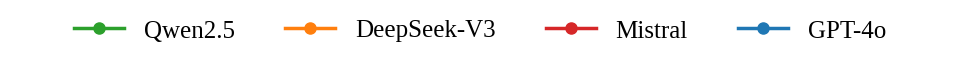

In [30]:
# 创建独立的图例图（单独一个figure）
fig_leg = plt.figure(figsize=(10, 0.8))  # 调整宽度和高度
fig_leg.legend(
    handles=legend_handles,
    loc='center',
    ncol=4,  # 水平排列的关键参数
    fontsize=18,
    frameon=False  # 去掉图例边框
)
plt.axis('off')  # 隐藏坐标轴
plt.tight_layout()
plt.show()

In [33]:
#单个模型的结果分析
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

groups = ["revised_qwen", "control_single_revised_qwen", "control_multi_revised_qwen"]
# groups = ["revised_ds", "control_single_revised_ds", "control_multi_revised_ds"]
# groups = ["revised_mistral", "control_single_revised_mistral", "control_multi_revised_mistral"]
# groups = ["pure_ds", "initial_ds", "revised_ds","voted_ds"]
# groups = ["pure_qwen", "initial_qwen", "revised_qwen","voted_qwen"]
# groups = ["pure_mistral", "initial_mistral", "revised_mistral","voted_mistral"]
data = {
    'Group': sum([[group] * sample_len for group in groups], []),  # 按组名填充
    'ja': sum([eval(group)[0] for group in groups], []),  # ja 数据
    'f1': sum([eval(group)[1] for group in groups], []),  # avg_f1 数据
    # 'ddi': sum([eval(group)[2] for group in groups], []),  # ddi 数据
}
data_ddi = {
    'Group': sum([[group] * 10 for group in groups], []),  # 按组名填充
    'ddi': sum([eval(group)[2] for group in groups], []),  # ddi 数据
}

df = pd.DataFrame(data)
df_ddi = pd.DataFrame(data_ddi)

# 1. 对ja进行单因素方差分析
f_stat_ja, p_value_ja = stats.f_oneway(df[df['Group'] == groups[0]]['ja'],
                                        df[df['Group'] == groups[1]]['ja'],
                                        df[df['Group'] == groups[2]]['ja'])

print(f"ja的F统计量: {f_stat_ja}, p值: {p_value_ja}")

if p_value_ja < 0.05:
    print("ja: 拒绝零假设，三组之间存在显著差异")
    
    # 进行Tukey HSD事后检验
    tukey_ja = pairwise_tukeyhsd(df['ja'], df['Group'])
    print(tukey_ja)
else:
    print("ja: 不能拒绝零假设，三组之间没有显著差异")


# 2. 对avg_f1进行单因素方差分析
f_stat_f1, p_value_f1 = stats.f_oneway(df[df['Group'] == groups[0]]['f1'],
                                                df[df['Group'] == groups[1]]['f1'],
                                                df[df['Group'] == groups[2]]['f1'])

print(f"f1的F统计量: {f_stat_f1}, p值: {p_value_f1}")

if p_value_f1 < 0.05:
    print("f1: 拒绝零假设，三组之间存在显著差异")
    
    # 进行Tukey HSD事后检验
    tukey_f1 = pairwise_tukeyhsd(df['f1'], df['Group'])
    print(tukey_f1)
else:
    print("f1: 不能拒绝零假设，三组之间没有显著差异")


# 3. 对ddi进行单因素方差分析
f_stat_ddi, p_value_ddi = stats.f_oneway(df_ddi[df_ddi['Group'] == groups[0]]['ddi'],
                                          df_ddi[df_ddi['Group'] == groups[1]]['ddi'],
                                          df_ddi[df_ddi['Group'] == groups[2]]['ddi'])

print(f"ddi的F统计量: {f_stat_ddi}, p值: {p_value_ddi}")

if p_value_ddi < 0.05:
    print("ddi: 拒绝零假设，三组之间存在显著差异")
    
    # 进行Tukey HSD事后检验
    tukey_ddi = pairwise_tukeyhsd(df_ddi['ddi'], df_ddi['Group'])
    print(tukey_ddi)
else:
    print("ddi: 不能拒绝零假设，三组之间没有显著差异")


ja的F统计量: 5.631880483522534, p值: 0.003664656490663012
ja: 拒绝零假设，三组之间存在显著差异
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
           group1                      group2           meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------
 control_multi_revised_qwen control_single_revised_qwen   0.0233 0.0114  0.0043  0.0423   True
 control_multi_revised_qwen                revised_qwen  -0.0005  0.998 -0.0195  0.0185  False
control_single_revised_qwen                revised_qwen  -0.0238 0.0095 -0.0428 -0.0048   True
----------------------------------------------------------------------------------------------
f1的F统计量: 5.026514854605329, p值: 0.0066822889039706845
f1: 拒绝零假设，三组之间存在显著差异
                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
           group1                      group2           meandiff p-adj   lower   upper  rej

In [ ]:
#计算效应值cohen


In [6]:
avg_std = [eval(group)[3] for group in groups]
print(avg_std[0]) # ja_avg, ja_std, f1_avg, f1_std, ddi_avg, ddi_std

[0.3711065561907498, 0.0030689134677812703, 0.5300078020011973, 0.004371751888090807, 0.0661006069149835, 0.0010022588886666672]


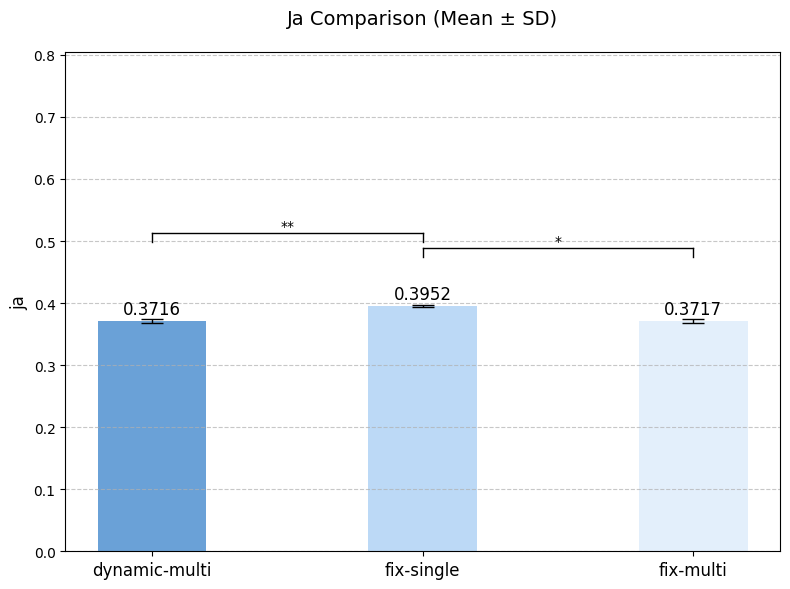

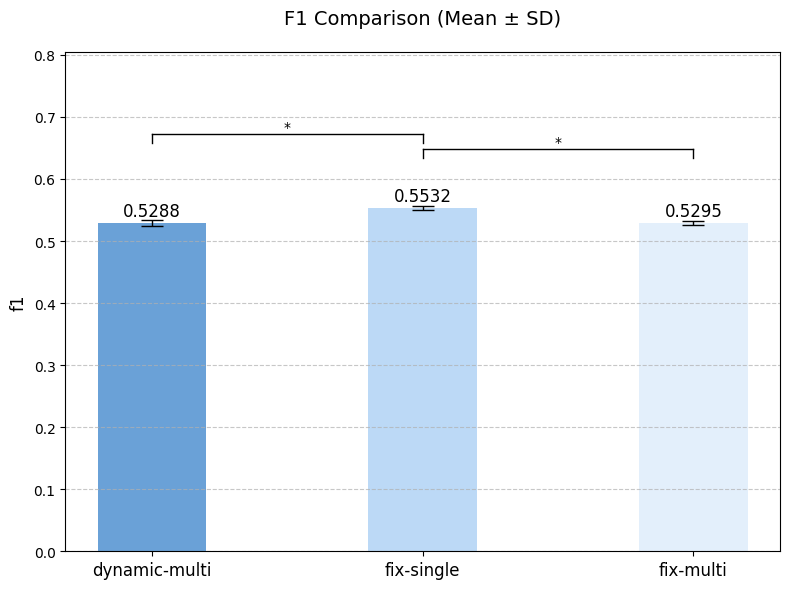

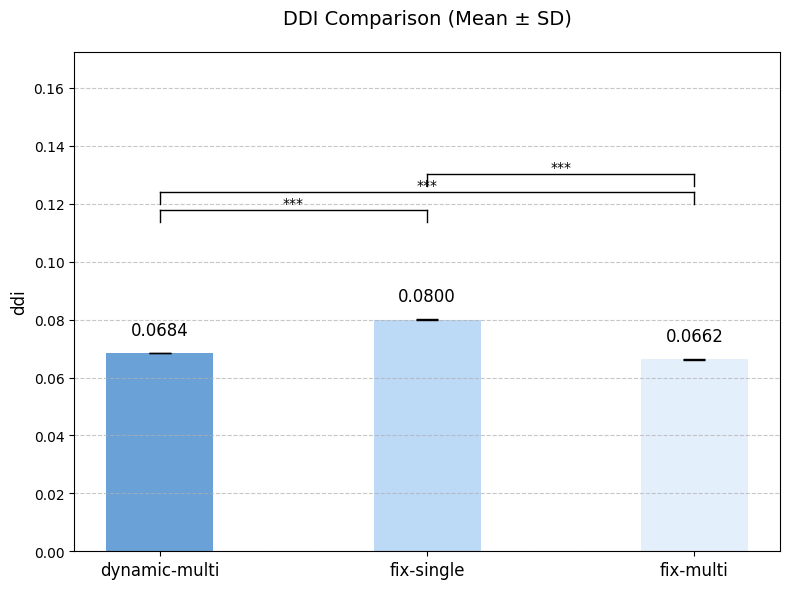

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_significance(ax, x1, x2, y, text, y_max, line_height=0.02, tick_length=0.015):
    """改进的显著性标记绘制，带两端竖线"""
    if y_max >=0.7:
        # 绘制水平线
        ax.plot([x1, x2], [y+0.09, y+0.09], color='k', lw=1)
        # 绘制两端竖线
        ax.plot([x1, x1], [y+0.09, y+0.09-tick_length], color='k', lw=1)  # 左端竖线
        ax.plot([x2, x2], [y+0.09, y+0.09-tick_length], color='k', lw=1)  # 右端竖线
        # 调整文本位置到线上方
        ax.text((x1 + x2)*0.5, y+0.09 , text, 
            ha='center', va='bottom', color='k', fontsize=10)
    else:
        tick_length = 0.004 #0.035
        ax.plot([x1, x2], [y+0.05, y+0.05], color='k', lw=1) 
        # 绘制两端竖线
        ax.plot([x1, x1], [y+0.05, y+0.05-tick_length], color='k', lw=1)  # 左端竖线
        ax.plot([x2, x2], [y+0.05, y+0.05-tick_length], color='k', lw=1)  # 右端竖线
        # 调整文本位置到线上方
        ax.text((x1 + x2)*0.5, y+0.05, text, 
            ha='center', va='bottom', color='k', fontsize=10)

def plot_group_comparison(df, metric, tukey_result, title, groups, y_max=None):
    group_data = [df[df['Group'] == g][metric] for g in groups]
    
    # 计算统计量
    means = [multi_test_anova(d)[0] for d in group_data] 
    stds = [multi_test_anova(d)[1] for d in group_data]
    x = np.arange(len(groups))
    x = np.arange(len(groups))  # 默认是连续的
    # 改变间距
    spacing_factor = 0.5 
    x = x * spacing_factor  
    # 创建图表
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(x, means, yerr=stds, capsize=8, width=0.2,
                 color=['#6AA1D7', '#BCD9F6', '#E3EFFB'],
                #  color=['#c0c0c0','#6AA1D7', '#BCD9F6', '#E3EFFB'],
                 error_kw={'elinewidth': 1, 'capthick': 1})
    
    # 图表装饰
    ax.set_xticks(x)
    labels = ["pure", "initial", "adjudicated", "voted"]
    labels = ["dynamic-multi", "fix-single", "fix-multi"]
    ax.set_xticklabels(labels, fontsize=12)  # 设置刻度标签
    # ax.set_xticklabels(groups, fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{title} (Mean ± SD)', fontsize=14, pad=20)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # # 设置纵坐标范围
    # if y_max is not None:
    #     ax.set_ylim(top=y_max)
    # else:
    #     y_max = max(means) + max(stds) + 0.1*(max(means)-min(means))
    #     ax.set_ylim(top=y_max)
    # 设置纵坐标范围，适当增加 y_max，确保显著性标记不会超出图表
    if y_max is not None:
        y_max += 0.15 * y_max  # 适当增加 15% 的 y_max
        ax.set_ylim(top=y_max)
    else:
        y_max = max(means) + max(stds) + 0.1*(max(means)-min(means))
        y_max += 0.15 * y_max  # 增加 15% 的范围
        ax.set_ylim(top=y_max)

    
    # 显示柱状图上的数值
    for i, bar in enumerate(bars):
        height = bar.get_height()  # 获取柱子的高度
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005,  # 在柱子上方显示 height + 0.02,
                f'{height:.4f}',  # 显示数值，保留2位小数
                ha='center', va='bottom', fontsize=12)
        
    # 提取显著性结果
    tukey_df = pd.DataFrame(tukey_result._results_table.data[1:], 
                           columns=tukey_result._results_table.data[0])
    significant_pairs = tukey_df[tukey_df['reject']]
    
    # 自动确定标注高度
    # 确定标注基准高度
    base_height = max(means) + max(stds) * 1.2
    current_y = base_height
    
    # 绘制显著性标记
    for _, row in significant_pairs.iterrows():
        group1 = row['group1']
        group2 = row['group2']
        x1 = groups.index(group1) * spacing_factor
        x2 = groups.index(group2) * spacing_factor
        
        p_val = row['p-adj']
        # 确定显著性符号
        if p_val < 0.001:
            symbol = '***'
        elif p_val < 0.01:
            symbol = '**'
        elif p_val < 0.05:
            symbol = '*'
        else:
            continue
        
        # 绘制标记
        plot_significance(ax, x1, x2, current_y, symbol,y_max, line_height=0.01)
        if y_max >=0.7:
            minus_height = 0.04
        else:
            minus_height = 0.02
        current_y += (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.08 - minus_height  # 自适应高度增量避免重叠

    
    # 显示图形
    # plt.show()
    plt.tight_layout()

# 对每个指标生成图表，传递对应的y_max值
plot_group_comparison(df, 'ja', tukey_ja, 'Ja Comparison', groups, y_max=0.7)
plot_group_comparison(df, 'f1', tukey_f1, 'F1 Comparison', groups, y_max=0.7)
plot_group_comparison(df_ddi, 'ddi', tukey_ddi, 'DDI Comparison', groups, y_max=0.15)


## ----------------

In [ ]:
rag_pred_path_1 = "//home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-12_rag_mimic3.json"
rag_pred_path_2 = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-10_rag_mimic3.json"
# ja, avg_p, avg_r, avg_f1, ddi 
res_1 = evaluate_jsonlines(rag_pred_path_1, ehr_tokenizer, threshold=0.5)
res_2= evaluate_jsonlines(rag_pred_path_2, ehr_tokenizer, threshold=0.5) #threshold改0.16到0.5

print(res_1)
print(res_2)  # ja, avg_p, avg_r, avg_f1, ddi


In [ ]:
#简单看一下。这是第一次修正后的结果
import json
# no_rag_pred_path_0107 = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-07_no_rag_mimic3.json"
# rag_pred_path_0110 = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-10_rag_mimic3.json"
pure_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/common_entries_pure.json"
# pure_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-11_pure_mimic3.json"
no_rag_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/common_entries_no_rag.json" #测试结果文件
rag_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/common_entries_rag.json"
# ja, avg_p, avg_r, avg_f1, ddi 
res_pure = evaluate_jsonlines(pure_pred_path, ehr_tokenizer, threshold=0.5)
res_no_rag= evaluate_jsonlines(no_rag_pred_path, ehr_tokenizer, threshold=0.5) #threshold改0.16到0.5
res_rag= evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5) 
print(res_pure)
print(res_no_rag)  # ja, avg_p, avg_r, avg_f1, ddi
print(res_rag)

In [ ]:
#以这个为准
# ddi = evaluate_jsonlines(pred_path, ehr_tokenizer, threshold=0.5)
# pure_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/test_predictions.json"
pure_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/common_entries_pure.json"
no_rag_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/common_entries_no_rag.json" #测试结果文件
rag_pred_path = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/common_entries_rag.json"

# ja, avg_p, avg_r, avg_f1, ddi 
res_pure = evaluate_jsonlines(pure_pred_path, ehr_tokenizer, threshold=0.5)
res_no_rag= evaluate_jsonlines(no_rag_pred_path, ehr_tokenizer, threshold=0.5) #threshold改0.16到0.5
res_rag= evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5) 
print(res_pure)
print(res_no_rag)  # ja, avg_p, avg_r, avg_f1, ddi
print(res_rag)

In [ ]:
(0.25717183688071577, 0.550953922118071, 0.34041170015902344, 0.39857034320593043, 0.10745916158236568)
(0.22390160259060987, 0.5605392469455341, 0.28680408137026364, 0.35518187740375295, 0.13682040711156918)
(0.2506913809403608, 0.5917468014470532, 0.3128586921451086, 0.39123716472183184, 0.13598074608904934)

## Find Top_n --遇到冲突时限制常用药前n个药物不进行替换

In [ ]:
top_n_list = [10, 20, 25, 30, 40, 50, 60, 70, 80, 90]#--30
# top_n_list = [10, 20, 25, 30, 40, 50, 60]
# top_n_list = [30]
for top_n in top_n_list:
    rag_pred_path = f"/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/find_top_n/2025-01-28_top_{top_n}_rag_mimic3.json"
    res_first = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "first")
    res_second = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "second")
    res_final = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "final")
    print(f"---------------------top_{top_n} result:---------------------------------------------------------")
    print("res_first:", res_first)
    print("res_second:", res_second)
    print("res_final:", res_final)




# 1. 冲突分类 + 进一步分析

In [26]:
import json
analyze_data_paths = ['/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-10_classify_analyze_200-600_rag_mimic3.json',
                      "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-11_classify_analyze_100-200_rag_mimic3.json",
                      "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-11_classify_analyze_0-100_rag_mimic3.json"
                      ] #Qwen
analyze_data_paths = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-04-27_classify_analyze_rag_mimic3.json"] #ds

analyze_samples = []
for analyze_data_path in analyze_data_paths:
    with open(analyze_data_path, "r", encoding="utf-8") as file:
        analyze_sample = json.load(file)
        analyze_samples += analyze_sample
print(len(analyze_samples))

425


In [ ]:
###合并分析文件
import json

# 加载第一个文件
with open("/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-04-27_classify_analyze_rag_mimic3.json", "r", encoding="utf-8") as file:
    data1 = json.load(file)

# 加载第二个文件
with open("/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_deepseek_all_node2_rag_mimic3.json", "r", encoding="utf-8") as file:
    data2 = json.load(file)

# 创建一个以patient_condition为键的字典，方便快速查找
data2_dict = {item["patient_condition"]: item for item in data2}

# 合并数据
merged_data = []
for item1 in data1:
    patient_condition = item1["patient_condition"]
    if patient_condition in data2_dict:
        # 合并两个条目，这里假设你想保留所有字段
        merged_item = {**item1, **data2_dict[patient_condition]}
        merged_data.append(merged_item)
    else:
        # 如果第二个文件中没有匹配项，只保留第一个文件的条目
        merged_data.append(item1)

# 检查是否有第二个文件中的条目未被合并
for item2 in data2:
    patient_condition = item2["patient_condition"]
    if not any(item["patient_condition"] == patient_condition for item in data1):
        merged_data.append(item2)

# 打印合并后的数据量
print(f"合并后的数据条数: {len(merged_data)}")

# 保存合并后的文件（可选）
# with open("merged_output.json", "w", encoding="utf-8") as file:
#     json.dump(merged_data, file, ensure_ascii=False, indent=4)

合并后的数据条数: 461


## -- 1.0 修改药方的行为包括：
替换同功能药物（这里将删除和添加同样的ATC3级药物视作替换）
删除药物
增加药物


In [28]:
# here put the import lib
import copy
import os
import pickle
import numpy as np
from utils import ddi_rate_score, EHRTokenizer

voc_dir = "/home/wuyicong/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled/voc_final.pkl" #处理数据集的时候构建好的
ehr_tokenizer = EHRTokenizer(voc_dir)

def get_ddi(data_path, ehr_tokenizer,ddi_path='/home/wuyicong/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled'):
    experient_data = []
    experient_data.append(data_path)
       
    true_pred_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    pred_label = []

    def filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes):
        # 过滤掉不存在的 code
        valid_codes = [code for code in predict_atc_codes if code in ehr_tokenizer.med_voc.word2idx]
        # 将有效的 code 转换为 id
        valid_ids = ehr_tokenizer.convert_med_tokens_to_ids(valid_codes)
        return valid_ids

    for row, meta_data in enumerate(experient_data):
        predict_atc_codes = meta_data
        predict_atc_codes = [item[:4] for item in predict_atc_codes if len(item) >= 4]
        predict_atc_codes = list(set(predict_atc_codes)) #去重
        true_pred_index = filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes)
        true_pred_data[row][true_pred_index] = 1

    meta_label = [np.where(row == 1)[0].tolist() for row in true_pred_data]
    pred_label.append([sorted(sub_array) for sub_array in meta_label])

    ddi_adj = pickle.load(open(os.path.join(ddi_path, 'ddi_A_final.pkl'), 'rb'))
    ddi = ddi_rate_score(pred_label, ddi_adj)
    return ddi

#某个操作使得冲突率下降，则认为是正确的操作；反之。
additional_paths = ['/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-21_analyze_rag_mimic3.json',
                      "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-26_analyze_100-200_rag_mimic3.json",
                      "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-03_analyze_200-600_rag_mimic3.json"
                      ]
additional_paths = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/2025-04-27_analyze_rag_mimic3.json"]
addtitional_analyze_samples = []
for additional_path in additional_paths:
    with open(additional_path, "r", encoding="utf-8") as file:
        addtitional_analyze_sample = json.load(file)
        addtitional_analyze_samples += addtitional_analyze_sample
print(len(addtitional_analyze_samples))


merged_dict = {}

# 先处理analyze_samples
for item in analyze_samples:
    patient_condition = item["patient_condition"]
    merged_dict[patient_condition] = item # 将analyze_samples的数据加入字典

# 再处理addtitional_analyze_samples
for item in addtitional_analyze_samples:
    patient_condition = item["patient_condition"]
    if patient_condition in merged_dict:
        merged_dict[patient_condition].update(item)  # 如果patient_condition已经在字典中，合并数据

# 生成最终的test_samples列表
test_samples = list(merged_dict.values())

# 输出合并后的结果
print(len(test_samples))


461
425


In [34]:
data = {
    "deleted_atc_codes": ["H02A", "D07A"],
    "added_atc_codes": ["D07A", "H02A", "j09i"]
}

# 找出交集
common_codes = set(data["deleted_atc_codes"]) & set(data["added_atc_codes"])
common_count = len(common_codes)
print(common_codes, common_count)

# 从两者中删除交集元素
if common_codes:
    data["deleted_atc_codes"] = [code for code in data["deleted_atc_codes"] if code not in common_codes]
    data["added_atc_codes"] = [code for code in data["added_atc_codes"] if code not in common_codes]

print(data)

{'D07A', 'H02A'} 2
{'deleted_atc_codes': [], 'added_atc_codes': ['j09i']}


In [48]:
drug_drug_num = 0
drug_disease_num = 0
total_single_discuss = 0
total_multi_discuss = 0
single_discuss_res = {}
multi_discuss_res = {}
import re
for analyze_sample in test_samples:
    classified_conflict = analyze_sample["conflicts_classify"]
    single_discuss = analyze_sample["single_discuss"]
    multi_discuss = analyze_sample["multi_discuss"]
    first_medicine_code = analyze_sample["first_medicine"]["atc3_code_list"]
    first_medicine_ddi = get_ddi(first_medicine_code, ehr_tokenizer)
    total_single_discuss += len(single_discuss)
    total_multi_discuss += len(multi_discuss)
    for classified_conflict_item in classified_conflict:
        # print(classified_conflict_item)
        conflict_belong = ''
        match = re.search(r"conflict (\d+)", classified_conflict_item, re.IGNORECASE)
        if match:
            conflict_number = match.group(1)
        if "disease" in classified_conflict_item.lower():
            drug_disease_num += 1
            conflict_belong = "drug_disease"
        else:
            drug_drug_num += 1
            conflict_belong = "drug_drug"
            
        for single_discuss_item in single_discuss: ###
            if single_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none", "replace"]
                for del_or_add in del_or_add_list: #先全部归0
                    single_discuss_item[f"{del_or_add}"] = 0
                
                ###增加替换统计
                common_codes = {}
                common_codes = set(single_discuss_item["deleted_atc_codes"]) & set(single_discuss_item["added_atc_codes"])
                common_count = len(common_codes)
                # 从两者中删除交集元素
                if common_codes:
                    single_discuss_item["deleted_atc_codes"] = [code for code in single_discuss_item["deleted_atc_codes"] if code not in common_codes]
                    single_discuss_item["added_atc_codes"] = [code for code in single_discuss_item["added_atc_codes"] if code not in common_codes]
                single_discuss_item["replace"] += common_count
                
                for deleted_item in single_discuss_item["deleted_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    # print(deleted_item, adjusted_medicine_code)
                    if deleted_item in adjusted_medicine_code:
                        adjusted_medicine_code.remove(deleted_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        single_discuss_item["deleted_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        single_discuss_item["deleted_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        single_discuss_item["deleted_none"] += 1

                for added_item in single_discuss_item["added_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    adjusted_medicine_code.append(added_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        single_discuss_item["added_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        single_discuss_item["added_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        single_discuss_item["added_none"] += 1
                
                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_single_discuss_{del_or_add}"
                    single_discuss_res[key] = single_discuss_res.get(key, 0) + single_discuss_item[f"{del_or_add}"]
        # print('1111')
        for multi_discuss_item in multi_discuss:
            if multi_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none", "replace"]
                
                for del_or_add in del_or_add_list: #先全部归0
                    multi_discuss_item[f"{del_or_add}"] = 0

                ###增加替换统计
                common_codes = {}
                common_codes = set(multi_discuss_item["deleted_atc_codes"]) & set(multi_discuss_item["added_atc_codes"])
                common_count = len(common_codes)
                # 从两者中删除交集元素
                if common_codes:
                    multi_discuss_item["deleted_atc_codes"] = [code for code in multi_discuss_item["deleted_atc_codes"] if code not in common_codes]
                    multi_discuss_item["added_atc_codes"] = [code for code in multi_discuss_item["added_atc_codes"] if code not in common_codes]
                multi_discuss_item["replace"] += common_count
                
                for deleted_item in multi_discuss_item["deleted_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    if deleted_item in adjusted_medicine_code:
                        adjusted_medicine_code.remove(deleted_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        multi_discuss_item["deleted_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        multi_discuss_item["deleted_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        multi_discuss_item["deleted_none"] += 1

                for added_item in multi_discuss_item["added_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    adjusted_medicine_code.append(added_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        multi_discuss_item["added_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        multi_discuss_item["added_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        multi_discuss_item["added_none"] += 1

                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_multi_discuss_{del_or_add}"
                    multi_discuss_res[key] = multi_discuss_res.get(key, 0) + multi_discuss_item[f"{del_or_add}"]


In [ ]:

with open("/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/test_rag_mimic3.json", "a", encoding="utf-8") as file:
    json.dump(test_samples[2], file, ensure_ascii=False, indent=4)
    file.write("\n")

In [67]:
print(809+1721)

2530


In [49]:
import pprint as pp
print(total_single_discuss)
print(total_multi_discuss)
print(drug_drug_num)
print(drug_disease_num)
pp.pprint(single_discuss_res)
pp.pprint(multi_discuss_res)

809
1721
2378
602
{'drug_disease_single_discuss_added_none': 27,
 'drug_disease_single_discuss_added_right': 9,
 'drug_disease_single_discuss_added_wrong': 26,
 'drug_disease_single_discuss_deleted_none': 72,
 'drug_disease_single_discuss_deleted_right': 72,
 'drug_disease_single_discuss_deleted_wrong': 31,
 'drug_disease_single_discuss_replace': 0,
 'drug_drug_single_discuss_added_none': 164,
 'drug_drug_single_discuss_added_right': 37,
 'drug_drug_single_discuss_added_wrong': 89,
 'drug_drug_single_discuss_deleted_none': 257,
 'drug_drug_single_discuss_deleted_right': 299,
 'drug_drug_single_discuss_deleted_wrong': 117,
 'drug_drug_single_discuss_replace': 3}
{'drug_disease_multi_discuss_added_none': 86,
 'drug_disease_multi_discuss_added_right': 32,
 'drug_disease_multi_discuss_added_wrong': 29,
 'drug_disease_multi_discuss_deleted_none': 180,
 'drug_disease_multi_discuss_deleted_right': 131,
 'drug_disease_multi_discuss_deleted_wrong': 40,
 'drug_disease_multi_discuss_replace': 26,

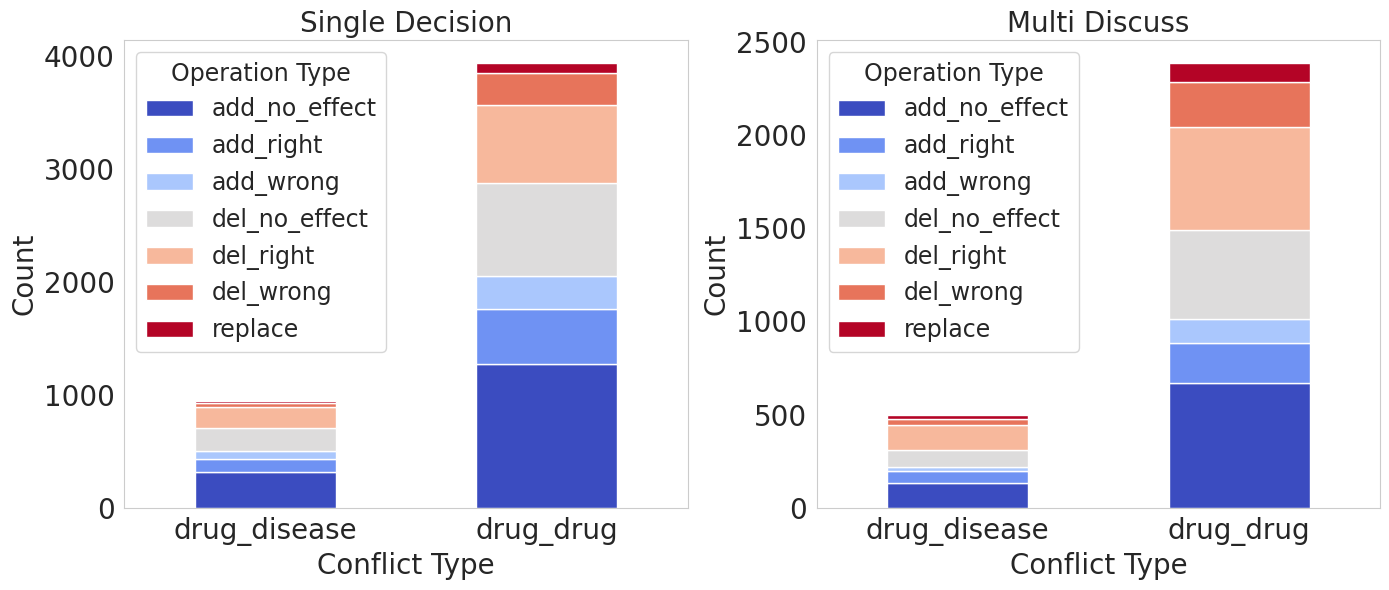

Single Discuss Table:
             add_no_effect add_right add_wrong del_no_effect del_right  \
drug_disease        32.95%    12.67%     7.60%        21.75%    19.01%   
drug_drug           32.28%    12.31%     7.46%        20.89%    17.54%   

             del_wrong replace  
drug_disease     4.01%   2.01%  
drug_drug        7.08%   2.44%  

Multi Discuss Table:
             add_no_effect add_right add_wrong del_no_effect del_right  \
drug_disease        26.80%    12.40%     4.00%        18.80%    26.40%   
drug_drug           27.93%     9.09%     5.28%        20.10%    23.24%   

             del_wrong replace  
drug_disease     7.20%   4.40%  
drug_drug       10.05%   4.31%  


/tmp/ipykernel_1912074/2935016588.py:68: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_single_percentage = df_single_percentage.applymap(format_percentage)
/tmp/ipykernel_1912074/2935016588.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_multi_percentage = df_multi_percentage.applymap(format_percentage)


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 数据
data_single = {
    'add_no_effect': [312, 1272],
    'add_right': [120, 485],
    'add_wrong': [72, 294],
    'del_no_effect': [206, 823],
    'del_right': [180, 691],
    'del_wrong': [38, 279],
    'replace': [19, 96]
}

data_multi = {
    'add_no_effect': [134, 667],
    'add_right': [62, 217],
    'add_wrong': [20, 126],
    'del_no_effect': [94, 480],
    'del_right': [132, 555],
    'del_wrong': [36, 240],
    'replace': [22, 103]
}

categories = ['drug_disease', 'drug_drug']
df_single = pd.DataFrame(data_single, index=categories)
df_multi = pd.DataFrame(data_multi, index=categories)

# 计算占比
df_single_percentage = df_single.div(df_single.sum(axis=1), axis=0) * 100
df_multi_percentage = df_multi.div(df_multi.sum(axis=1), axis=0) * 100


# 画图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_style("whitegrid")

df_single.plot(kind='bar', stacked=True, ax=axes[0], colormap='coolwarm')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].set_title("Single Decision", fontsize=20)
axes[0].set_ylabel("Count", fontsize=20)
axes[0].set_xlabel("Conflict Type", fontsize=20)
axes[0].legend(title="Operation Type", fontsize=17)
legend = axes[0].legend(title="Operation Type", fontsize=17)
legend.get_title().set_fontsize(17) 

df_multi.plot(kind='bar', stacked=True, ax=axes[1], colormap='coolwarm')
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[1].set_title("Multi Discuss", fontsize=20)
axes[1].set_ylabel("Count", fontsize=20)
axes[1].set_xlabel("Conflict Type", fontsize=20)
axes[1].legend(title="Operation Type", fontsize=17)
legend = axes[1].legend(title="Operation Type", fontsize=17)
legend.get_title().set_fontsize(17) 

axes[0].tick_params(axis='x', labelsize=20)  # 增大单讨论图的横坐标刻度字体
axes[1].tick_params(axis='x', labelsize=20)  # 增大多讨论图的横坐标刻度字体
axes[0].grid(False)
axes[1].grid(False)
plt.tight_layout()
plt.show()

# 生成表格
def format_percentage(value):
    return f"{value:.2f}%"

df_single_percentage = df_single_percentage.applymap(format_percentage)
df_multi_percentage = df_multi_percentage.applymap(format_percentage)

print("Single Discuss Table:")
print(df_single_percentage)
print("\nMulti Discuss Table:")
print(df_multi_percentage)


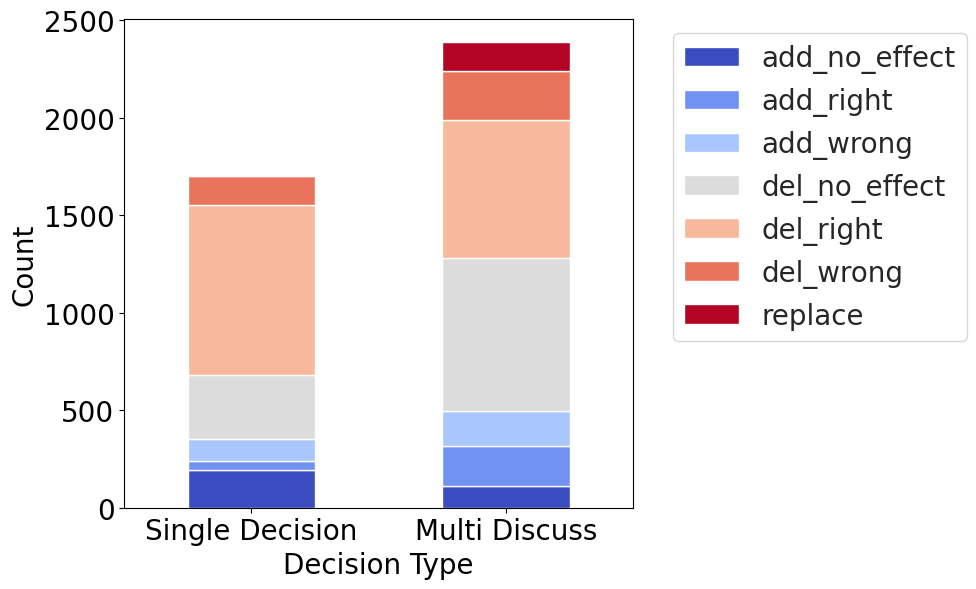


决策类型操作占比对比表：
                add_no_effect add_right add_wrong del_no_effect del_right del_wrong replace
Single Decision        11.22%      2.7%     6.75%        19.32%    51.15%     8.69%   0.18%
Multi Discuss            4.7%     8.55%     7.46%        32.91%    29.73%    10.57%   6.08%


/tmp/ipykernel_2668302/730686964.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  styled_table = percentage_table.applymap(add_percent)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 数据（保持不变）
data_single = {
    'add_no_effect': [27, 164],
    'add_right': [9, 37],
    'add_wrong': [26, 89],#115
    'del_no_effect': [72, 257],
    'del_right': [180, 691], #871
    'del_wrong': [31, 117],
    'replace': [0, 3]
}

data_multi = {
    'add_no_effect': [86, 26],
    'add_right': [32, 172],
    'add_wrong': [29, 149],#178
    'del_no_effect': [180, 605],
    'del_right': [131, 578],#709
    'del_wrong': [40, 212],
    'replace': [26, 119]
}

categories = ['drug_disease', 'drug_drug']
df_single = pd.DataFrame(data_single, index=categories)
df_multi = pd.DataFrame(data_multi, index=categories)

# 合并数据（关键修改：转置数据结构）
df_combined = pd.DataFrame({
    'Single Decision': df_single.sum(axis=0),
    'Multi Discuss': df_multi.sum(axis=0)
}).T  # 转置矩阵，使决策类型成为行

# 画图
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

# 使用颜色映射支持更多分类
colors = sns.color_palette("husl", n_colors=len(df_combined.columns))
df_combined.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm')

# 设置标题和标签
# ax.set_title("Decision Types: Single vs Multi", fontsize=20)
ax.set_xlabel("Decision Type", fontsize=20)  # 修改坐标轴标签
ax.set_ylabel("Count", fontsize=20)

# 调整图例位置和样式
# ax.legend(title="Operation Type", fontsize=17)
ax.legend(
    # title="Operation Type",
    fontsize=20,
    bbox_to_anchor=(1.05, 1),  # 将图例移到右侧外部
    loc='upper left'
)

# 设置坐标轴样式
ax.tick_params(axis='x', labelsize=20, rotation=0)  # 取消x轴标签旋转
ax.tick_params(axis='y', labelsize=20)
ax.set_xticklabels(['Single Decision', 'Multi Discuss'])  # 明确设置x轴标签

# 美化调整
ax.grid(False)
plt.tight_layout()

# 显示图形
plt.show()

# 重新计算百分比（按决策类型计算各操作占比）
# --------------------------------------------
# 计算每个决策类型的总样本数
single_total = df_combined.loc['Single Decision'].sum()
multi_total = df_combined.loc['Multi Discuss'].sum()

# 计算各操作类型占比（按决策类型）
percentage_table = pd.DataFrame({
    'Single Decision': (df_combined.loc['Single Decision'] / single_total * 100).round(2),
    'Multi Discuss': (df_combined.loc['Multi Discuss'] / multi_total * 100).round(2)
}).T  # 转置表格使决策类型成为行

# 添加百分号并格式化显示
def add_percent(val):
    return f"{val}%"

styled_table = percentage_table.applymap(add_percent)

# 打印美观的表格
print("\n决策类型操作占比对比表：")
print(styled_table.to_string())  # 使用to_string保持对齐

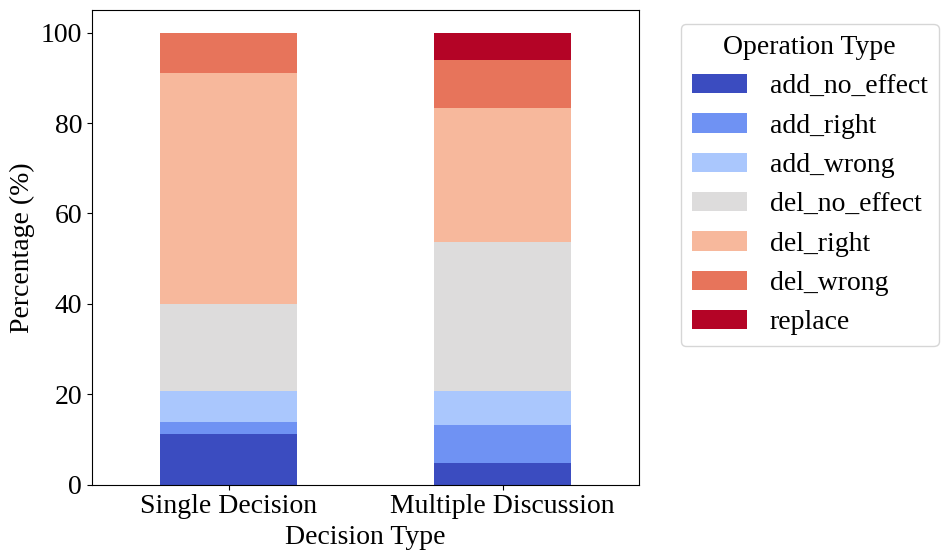

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams  # 导入全局字体设置模块

# === 1. 全局设置Times New Roman字体 ===
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Liberation Serif', 'DejaVu Serif', 'Nimbus Roman', 'STIXGeneral'] 
rcParams['font.size'] = 20  

# 构建 DataFrame
data = {
    '决策类型': ['Single Decision', 'Multiple Discussion'],
    'add_no_effect': [11.22, 4.7],
    'add_right': [2.7, 8.55],
    'add_wrong': [6.75, 7.46],
    'del_no_effect': [19.32, 32.91],
    'del_right': [51.15, 29.73],
    'del_wrong': [8.69, 10.57],
    'replace': [0.18, 6.08]
}

df = pd.DataFrame(data)
df.set_index('决策类型', inplace=True)

# 画堆叠柱状图
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')

# plt.title('决策类型操作占比对比')
plt.ylabel('Percentage (%)')
plt.xlabel('Decision Type')
plt.xticks(rotation=0)
plt.legend(title='Operation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## -- 1.1 根据删除或增加的药物导致药物冲突率的变化，来确定操作是否正确

In [23]:
# here put the import lib
import copy
import os
import pickle
import numpy as np
from utils import ddi_rate_score, EHRTokenizer

voc_dir = "/home/wuyicong/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled/voc_final.pkl" #处理数据集的时候构建好的
ehr_tokenizer = EHRTokenizer(voc_dir)

def get_ddi(data_path, ehr_tokenizer,ddi_path='/home/wuyicong/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled'):
    experient_data = []
    experient_data.append(data_path)
       
    true_pred_data = np.zeros((len(experient_data), len(ehr_tokenizer.med_voc.word2idx)))
    pred_label = []

    def filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes):
        # 过滤掉不存在的 code
        valid_codes = [code for code in predict_atc_codes if code in ehr_tokenizer.med_voc.word2idx]
        # 将有效的 code 转换为 id
        valid_ids = ehr_tokenizer.convert_med_tokens_to_ids(valid_codes)
        return valid_ids

    for row, meta_data in enumerate(experient_data):
        predict_atc_codes = meta_data
        predict_atc_codes = [item[:4] for item in predict_atc_codes if len(item) >= 4]
        predict_atc_codes = list(set(predict_atc_codes)) #去重
        true_pred_index = filter_and_convert_med_tokens_to_ids(ehr_tokenizer, predict_atc_codes)
        true_pred_data[row][true_pred_index] = 1

    meta_label = [np.where(row == 1)[0].tolist() for row in true_pred_data]
    pred_label.append([sorted(sub_array) for sub_array in meta_label])

    ddi_adj = pickle.load(open(os.path.join(ddi_path, 'ddi_A_final.pkl'), 'rb'))
    ddi = ddi_rate_score(pred_label, ddi_adj)
    return ddi

In [ ]:
# code = ['B01A', 'C08C', 'A03B', 'N03A', 'J01G', 'A12B', 'N06A', 'B05C', 'C01D', 'C10A', 'C09C', 'N05C', 'A07A', 'C03C', 'A04A', 'C09A', 'A06A', 'N02B', 'R05C', 'C07A', 'M01A', 'A01A', 'N05B', 'N02A', 'J01D', 'R03A', 'A10A', 'A02B', 'J01C', 'A12C', 'C03D', 'M03A', 'A03F', 'J01M']

# res = get_ddi(code, ehr_tokenizer)
# print(res)

In [24]:
#某个操作使得冲突率下降，则认为是正确的操作；反之。
additional_paths = ['/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-21_analyze_rag_mimic3.json',
                      "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-26_analyze_100-200_rag_mimic3.json",
                      "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-03_analyze_200-600_rag_mimic3.json"
                      ]
addtitional_analyze_samples = []
for additional_path in additional_paths:
    with open(additional_path, "r", encoding="utf-8") as file:
        addtitional_analyze_sample = json.load(file)
        addtitional_analyze_samples += addtitional_analyze_sample
print(len(addtitional_analyze_samples))

517


In [25]:

merged_dict = {}

# 先处理analyze_samples
for item in analyze_samples:
    patient_condition = item["patient_condition"]
    merged_dict[patient_condition] = item # 将analyze_samples的数据加入字典

# 再处理addtitional_analyze_samples
for item in addtitional_analyze_samples:
    patient_condition = item["patient_condition"]
    if patient_condition in merged_dict:
        merged_dict[patient_condition].update(item)  # 如果patient_condition已经在字典中，合并数据

# 生成最终的test_samples列表
test_samples = list(merged_dict.values())

# 输出合并后的结果
print(len(test_samples))


NameError: name 'analyze_samples' is not defined

In [43]:
drug_drug_num = 0
drug_disease_num = 0
total_single_discuss = 0
total_multi_discuss = 0
single_discuss_res = {}
multi_discuss_res = {}
import re
for analyze_sample in test_samples:
    classified_conflict = analyze_sample["conflicts_classify"]
    single_discuss = analyze_sample["single_discuss"]
    multi_discuss = analyze_sample["multi_discuss"]
    first_medicine_code = analyze_sample["first_medicine"]["atc3_code_list"]
    first_medicine_ddi = get_ddi(first_medicine_code, ehr_tokenizer)
    total_single_discuss += len(single_discuss)
    total_multi_discuss += len(multi_discuss)
    for classified_conflict_item in classified_conflict:
        # print(classified_conflict_item)
        conflict_belong = ''
        match = re.search(r"conflict (\d+)", classified_conflict_item, re.IGNORECASE)
        if match:
            conflict_number = match.group(1)
        if "disease" in classified_conflict_item.lower():
            drug_disease_num += 1
            conflict_belong = "drug_disease"
        else:
            drug_drug_num += 1
            conflict_belong = "drug_drug"
            
        for single_discuss_item in single_discuss:
            if single_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none"]
                for del_or_add in del_or_add_list: #先全部归0
                    single_discuss_item[f"{del_or_add}"] = 0
                
                for deleted_item in single_discuss_item["deleted_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    # print(deleted_item, adjusted_medicine_code)
                    if deleted_item in adjusted_medicine_code:
                        adjusted_medicine_code.remove(deleted_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        single_discuss_item["deleted_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        single_discuss_item["deleted_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        single_discuss_item["deleted_none"] += 1

                for added_item in single_discuss_item["added_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    adjusted_medicine_code.append(added_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        single_discuss_item["added_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        single_discuss_item["added_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        single_discuss_item["added_none"] += 1
                
                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_single_discuss_{del_or_add}"
                    single_discuss_res[key] = single_discuss_res.get(key, 0) + single_discuss_item[f"{del_or_add}"]
        # print('1111')
        for multi_discuss_item in multi_discuss:
            if multi_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none"]
                
                for del_or_add in del_or_add_list: #先全部归0
                    multi_discuss_item[f"{del_or_add}"] = 0
                
                for deleted_item in multi_discuss_item["deleted_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    if deleted_item in adjusted_medicine_code:
                        adjusted_medicine_code.remove(deleted_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        multi_discuss_item["deleted_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        multi_discuss_item["deleted_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        multi_discuss_item["deleted_none"] += 1

                for added_item in multi_discuss_item["added_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    adjusted_medicine_code.append(added_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        multi_discuss_item["added_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        multi_discuss_item["added_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        multi_discuss_item["added_none"] += 1

                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_multi_discuss_{del_or_add}"
                    multi_discuss_res[key] = multi_discuss_res.get(key, 0) + multi_discuss_item[f"{del_or_add}"]


In [ ]:

with open("/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/test_rag_mimic3.json", "a", encoding="utf-8") as file:
    json.dump(test_samples[2], file, ensure_ascii=False, indent=4)
    file.write("\n")

In [44]:
import pprint as pp
print(total_single_discuss)
print(total_multi_discuss)
print(drug_drug_num)
print(drug_disease_num)
pp.pprint(single_discuss_res)
pp.pprint(multi_discuss_res)

2170
1572
3220
684
{'drug_disease_single_discuss_added_none': 322,
 'drug_disease_single_discuss_added_right': 121,
 'drug_disease_single_discuss_added_wrong': 80,
 'drug_disease_single_discuss_deleted_none': 215,
 'drug_disease_single_discuss_deleted_right': 188,
 'drug_disease_single_discuss_deleted_wrong': 40,
 'drug_drug_single_discuss_added_none': 1330,
 'drug_drug_single_discuss_added_right': 495,
 'drug_drug_single_discuss_added_wrong': 322,
 'drug_drug_single_discuss_deleted_none': 867,
 'drug_drug_single_discuss_deleted_right': 725,
 'drug_drug_single_discuss_deleted_wrong': 297}
{'drug_disease_multi_discuss_added_none': 151,
 'drug_disease_multi_discuss_added_right': 63,
 'drug_disease_multi_discuss_added_wrong': 24,
 'drug_disease_multi_discuss_deleted_none': 99,
 'drug_disease_multi_discuss_deleted_right': 147,
 'drug_disease_multi_discuss_deleted_wrong': 38,
 'drug_drug_multi_discuss_added_none': 752,
 'drug_drug_multi_discuss_added_right': 222,
 'drug_drug_multi_discuss_a

In [45]:
def analyze_data(single_data, multi_data):
    scenarios = ['drug_disease', 'drug_drug']
    operations = ['added', 'deleted']
    # discussion_types 对应数据中键的部分：单个讨论使用 "single_discuss"，多个讨论使用 "multi_discuss"
    discussion_map = {
        'Single': 'single_discuss',
        'Multi': 'multi_discuss'
    }
    
    results = {}
    for disc_type, disc_key in discussion_map.items():
        results[disc_type] = {}
        # 遍历不同场景
        for scenario in scenarios:
            results[disc_type][scenario] = {}
            for op in operations:
                # 构造键名，例如：'drug_disease_single_discuss_added_none'
                key_none = f"{scenario}_{disc_key}_{op}_none"
                key_right = f"{scenario}_{disc_key}_{op}_right"
                key_wrong = f"{scenario}_{disc_key}_{op}_wrong"
                
                # 从数据字典中获取对应数值（默认 0）
                none_val = single_data.get(key_none, 0) if disc_type == 'Single' else multi_data.get(key_none, 0)
                right_val = single_data.get(key_right, 0) if disc_type == 'Single' else multi_data.get(key_right, 0)
                wrong_val = single_data.get(key_wrong, 0) if disc_type == 'Single' else multi_data.get(key_wrong, 0)
                total = right_val + wrong_val + none_val
                accuracy = (right_val / total) if total > 0 else None
                inaccuracy = (wrong_val / total) if total > 0 else None
                
                results[disc_type][scenario][op] = {
                    'none': none_val,
                    'right': right_val,
                    'wrong': wrong_val,
                    'total': total,
                    'accuracy': accuracy,
                    'inaccuracy': inaccuracy
                }
    return results

def print_analysis(single_data, multi_data):
    # 先计算各项指标
    results_single = analyze_data(single_data, {})['Single']
    results_multi  = analyze_data({}, multi_data)['Multi']
    scenarios = ['drug_disease', 'drug_drug']

    for scenario in scenarios:
        print(f"========== 场景：{scenario} ==========")
        
        # ------------------- 新增操作分析 -------------------
        single_added = results_single[scenario]['added']
        multi_added  = results_multi[scenario]['added']
        single_add_right_ratio = single_added['right']/(single_added['right'] + single_added['wrong'] + single_added['none'])
        multi_add_right_ratio = multi_added['right']/(multi_added['right'] + multi_added['wrong'] + multi_added['none'])
        single_add_wrong_ratio = single_added['wrong']/(single_added['wrong'] + single_added['wrong'] + single_added['none'])
        multi_add_wrong_ratio = multi_added['wrong']/(multi_added['wrong'] + multi_added['wrong'] + multi_added['none'])
        print("【新增操作】")
        print(f"  single decision: add_correctly = {single_added['right']}, add_incorrectly = {single_added['wrong']}, add_without_impact = {single_added['none']}, 正确新增率 = {single_add_right_ratio}, 错误新增率 = {single_add_wrong_ratio}")
        print(f"  multi discussion:  add_correctly = {multi_added['right']}, add_incorrectly = {multi_added['wrong']}, add_without_impact = {multi_added['none']}, 正确新增率 = {multi_add_right_ratio}, 错误新增率 = {multi_add_wrong_ratio}")
        
        # 对比分析：如果正确新增始终为 0，则“不新增”（none）才是理想结果
        if single_added['right'] == 0 and multi_added['right'] == 0:
            print("  分析: 两种方式均无正确的新增。")
        else:
            print("  分析")
        
        # ------------------- 删除操作分析 -------------------
        single_deleted = results_single[scenario]['deleted']
        multi_deleted  = results_multi[scenario]['deleted']
        print("\n【删除操作】")
        single_acc = single_deleted['accuracy']
        multi_acc  = multi_deleted['accuracy']
        single_inacc = single_deleted['inaccuracy']
        multi_inacc  = multi_deleted['inaccuracy']
        print(f"  single decision: delete_correctly = {single_deleted['right']}, delete_incorrectly = {single_deleted['wrong']}, delete_without_impact = {single_deleted['none']}, correctly_delete_rate  = {single_acc:.4f}, incorrectly_delete_rate = {single_inacc:.4f}" if single_acc is not None else "  单个讨论: 无删除操作数据")
        print(f"  multi discussion:  delete_correctly = {multi_deleted['right']}, delete_incorrectly = {multi_deleted['wrong']}, delete_without_impact = {multi_deleted['none']}, correctly_delete_rate  = {multi_acc:.4f}, incorrectly_delete_rate = {multi_inacc:.4f}" if multi_acc is not None else "  多个讨论: 无删除操作数据")
        
        # 对比分析：删除操作中正确率较高者更优
        if single_acc is not None and multi_acc is not None:
            if single_acc > multi_acc:
                print("  分析: 单个讨论在删除操作中表现更积极，正确率更高。")
            elif single_acc < multi_acc:
                print("  分析: 多个讨论在删除操作中表现更好。")
            else:
                print("  分析: 删除操作的正确率两者相当。")
        print("\n")  # 空行隔开不同场景
    
    # 运行分析程序
print_analysis(single_discuss_res, multi_discuss_res)


========== 场景：drug_disease ==========
【新增操作】
  single decision: add_correctly = 121, add_incorrectly = 80, add_without_impact = 322, 正确新增率 = 0.23135755258126195, 错误新增率 = 0.16597510373443983
  multi discussion:  add_correctly = 63, add_incorrectly = 24, add_without_impact = 151, 正确新增率 = 0.2647058823529412, 错误新增率 = 0.12060301507537688
  分析

【删除操作】
  single decision: delete_correctly = 188, delete_incorrectly = 40, delete_without_impact = 215, correctly_delete_rate  = 0.4244, incorrectly_delete_rate = 0.0903
  multi discussion:  delete_correctly = 147, delete_incorrectly = 38, delete_without_impact = 99, correctly_delete_rate  = 0.5176, incorrectly_delete_rate = 0.1338
  分析: 多个讨论在删除操作中表现更好。


========== 场景：drug_drug ==========
【新增操作】
  single decision: add_correctly = 495, add_incorrectly = 322, add_without_impact = 1330, 正确新增率 = 0.23055426176059618, 错误新增率 = 0.16312056737588654
  multi discussion:  add_correctly = 222, add_incorrectly = 139, add_without_impact = 752, 正确新增率 = 0.19946091644

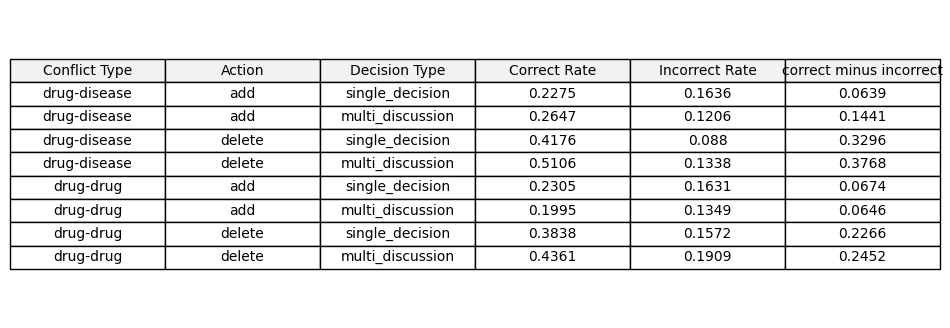

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

# 数据
data = {
    "drug-disease": {
        "add": {
            "single_decision": {"correct_rate": 0.2275, "incorrect_rate": 0.1636},
            "multi_discussion": {"correct_rate": 0.2647, "incorrect_rate": 0.1206}
        },
        "delete": {
            "single_decision": {"correct_rate": 0.4176, "incorrect_rate": 0.0880},
            "multi_discussion": {"correct_rate": 0.5106, "incorrect_rate": 0.1338}
        }
    },
    "drug-drug": {
        "add": {
            "single_decision": {"correct_rate": 0.2305, "incorrect_rate": 0.1631},
            "multi_discussion": {"correct_rate": 0.1995, "incorrect_rate": 0.1349}
        },
        "delete": {
            "single_decision": {"correct_rate": 0.3838, "incorrect_rate": 0.1572},
            "multi_discussion": {"correct_rate": 0.4361, "incorrect_rate": 0.1909}
        }
    }
}

# 准备数据用于创建表格
table_data = []

for conflict_type in data.keys():
    for action in data[conflict_type].keys():
        for decision_type in data[conflict_type][action].keys():
            row = {
                "Conflict Type": conflict_type,
                "Action": action,
                "Decision Type": decision_type,
                "Correct Rate": data[conflict_type][action][decision_type]["correct_rate"],
                "Incorrect Rate": data[conflict_type][action][decision_type]["incorrect_rate"],
                "correct minus incorrect": round(data[conflict_type][action][decision_type]["correct_rate"] - data[conflict_type][action][decision_type]["incorrect_rate"], 4)
            }
            table_data.append(row)

# 创建 DataFrame
df = pd.DataFrame(table_data)

# 创建表格并展示
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')  # 关闭坐标轴

# 使用 pandas 自带的 table 方法来绘制表格
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["#f2f2f2"]*df.shape[1])

# 设置表格样式
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.0, 1.4)  # 调整表格大小

# 显示表格
plt.show()


## -- 1.2 根据删除或增加的药物在target药物中的有无，来确定操作是否正确

In [29]:
# analyze_sample = analyze_samples[0]
drug_drug_num = 0
drug_disease_num = 0
total_single_discuss = 0
total_multi_discuss = 0
single_discuss_res = {}
multi_discuss_res = {}
import re
for analyze_sample in analyze_samples:
    classified_conflict = analyze_sample["conflicts_classify"]
    single_discuss = analyze_sample["single_discuss"]
    multi_discuss = analyze_sample["multi_discuss"]
    total_single_discuss += len(single_discuss)
    total_multi_discuss += len(multi_discuss)
    for classified_conflict_item in classified_conflict:
        # print(classified_conflict_item)
        conflict_belong = ''
        match = re.search(r"conflict (\d+)", classified_conflict_item, re.IGNORECASE)
        if match:
            conflict_number = match.group(1)
        if "disease" in classified_conflict_item.lower():
            drug_disease_num += 1
            conflict_belong = "drug_disease"
        else:
            drug_drug_num += 1
            conflict_belong = "drug_drug"
            
        for single_discuss_item in single_discuss:
            if single_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none"]
                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_single_discuss_{del_or_add}"
                    single_discuss_res[key] = single_discuss_res.get(key, 0) + single_discuss_item[f"{del_or_add}"]
        
        for multi_discuss_item in multi_discuss:
            if multi_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none"]
                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_multi_discuss_{del_or_add}"
                    multi_discuss_res[key] = multi_discuss_res.get(key, 0) + multi_discuss_item[f"{del_or_add}"]


In [7]:
import pprint as pp
print(total_single_discuss)
print(total_multi_discuss)
print(drug_drug_num)
print(drug_disease_num)
pp.pprint(single_discuss_res)
pp.pprint(multi_discuss_res)

2170
1572
3220
684
{'drug_disease_single_discuss_added_none': 312,
 'drug_disease_single_discuss_added_right': 120,
 'drug_disease_single_discuss_added_wrong': 72,
 'drug_disease_single_discuss_deleted_none': 206,
 'drug_disease_single_discuss_deleted_right': 180,
 'drug_disease_single_discuss_deleted_wrong': 38,
 'drug_drug_single_discuss_added_none': 1272,
 'drug_drug_single_discuss_added_right': 485,
 'drug_drug_single_discuss_added_wrong': 294,
 'drug_drug_single_discuss_deleted_none': 823,
 'drug_drug_single_discuss_deleted_right': 691,
 'drug_drug_single_discuss_deleted_wrong': 279}
{'drug_disease_multi_discuss_added_none': 134,
 'drug_disease_multi_discuss_added_right': 62,
 'drug_disease_multi_discuss_added_wrong': 20,
 'drug_disease_multi_discuss_deleted_none': 94,
 'drug_disease_multi_discuss_deleted_right': 132,
 'drug_disease_multi_discuss_deleted_wrong': 36,
 'drug_drug_multi_discuss_added_none': 667,
 'drug_drug_multi_discuss_added_right': 217,
 'drug_drug_multi_discuss_a

In [8]:


def analyze_data(single_data, multi_data):
    """
    根据输入的单个讨论和多个讨论的数据字典，
    计算每种场景下（drug_disease 和 drug_drug）、每种操作（added 和 deleted）的：
      - none（未操作）数值
      - right（正确操作）数值
      - wrong（错误操作）数值
      - 总操作数（right + wrong）
      - 正确率（如果 applicable）
    返回一个嵌套字典，结构为：
      results[discussion_type][scenario][operation] = {
          'none': int,
          'right': int,
          'wrong': int,
          'total': int,
          'accuracy': float or None  # accuracy 只对 total > 0 的情况计算
      }
    """
    scenarios = ['drug_disease', 'drug_drug']
    operations = ['added', 'deleted']
    # discussion_types 对应数据中键的部分：单个讨论使用 "single_discuss"，多个讨论使用 "multi_discuss"
    discussion_map = {
        'Single': 'single_discuss',
        'Multi': 'multi_discuss'
    }
    
    results = {}
    for disc_type, disc_key in discussion_map.items():
        results[disc_type] = {}
        # 遍历不同场景
        for scenario in scenarios:
            results[disc_type][scenario] = {}
            for op in operations:
                # 构造键名，例如：'drug_disease_single_discuss_added_none'
                key_none = f"{scenario}_{disc_key}_{op}_none"
                key_right = f"{scenario}_{disc_key}_{op}_right"
                key_wrong = f"{scenario}_{disc_key}_{op}_wrong"
                
                # 从数据字典中获取对应数值（默认 0）
                none_val = single_data.get(key_none, 0) if disc_type == 'Single' else multi_data.get(key_none, 0)
                right_val = single_data.get(key_right, 0) if disc_type == 'Single' else multi_data.get(key_right, 0)
                wrong_val = single_data.get(key_wrong, 0) if disc_type == 'Single' else multi_data.get(key_wrong, 0)
                total = right_val + wrong_val + none_val
                accuracy = ((right_val + none_val) / total) if total > 0 else None
                
                results[disc_type][scenario][op] = {
                    'none': none_val,
                    'right': right_val,
                    'wrong': wrong_val,
                    'total': total,
                    'accuracy': accuracy
                }
    return results


def print_analysis(single_data, multi_data):
    """
    根据单个讨论和多个讨论数据，输出各场景下新增和删除操作的详细对比分析。
    """
    # 先计算各项指标
    results_single = analyze_data(single_data, {})['Single']
    results_multi  = analyze_data({}, multi_data)['Multi']

    scenarios = ['drug_disease', 'drug_drug']

    for scenario in scenarios:
        print(f"========== 场景：{scenario} ==========")
        
        # ------------------- 新增操作分析 -------------------
        single_added = results_single[scenario]['added']
        multi_added  = results_multi[scenario]['added']
        single_add_right_ratio = single_added['right']/(single_added['right'] + single_added['wrong'] + single_added['none'])
        multi_add_right_ratio = multi_added['right']/(multi_added['right'] + multi_added['wrong'] + multi_added['none'])
        single_add_wrong_ratio = single_added['wrong']/(single_added['wrong'] + single_added['wrong'] + single_added['none'])
        multi_add_wrong_ratio = multi_added['wrong']/(multi_added['wrong'] + multi_added['wrong'] + multi_added['none'])
        print("【新增操作】")
        print(f"  单个讨论: 正确新增 = {single_added['right']}, 错误新增 = {single_added['wrong']}, 未新增 = {single_added['none']}, 正确新增率 = {single_add_right_ratio}, 错误新增率 = {single_add_wrong_ratio}")
        print(f"  多个讨论:  正确新增 = {multi_added['right']}, 错误新增 = {multi_added['wrong']}, 未新增 = {multi_added['none']}, 正确新增率 = {multi_add_right_ratio}, 错误新增率 = {multi_add_wrong_ratio}")
        
        # 对比分析：如果正确新增始终为 0，则“不新增”（none）才是理想结果
        if single_added['right'] == 0 and multi_added['right'] == 0:
            print("  分析: 两种方式均无正确新增，但多个讨论具备 abstain 能力（未新增数 > 0），有助于降低错误新增。")
        else:
            print("  分析: 注意检查新增逻辑，确保正确新增的条件是否满足。")
        
        # ------------------- 删除操作分析 -------------------
        single_deleted = results_single[scenario]['deleted']
        multi_deleted  = results_multi[scenario]['deleted']
        print("\n【删除操作】")
        single_acc = single_deleted['accuracy']
        multi_acc  = multi_deleted['accuracy']
        print(f"  单个讨论: 正确删除 = {single_deleted['right']}, 错误删除 = {single_deleted['wrong']}, 未删除 = {single_deleted['none']}, 正确率 = {single_acc:.2f}" if single_acc is not None else "  单个讨论: 无删除操作数据")
        print(f"  多个讨论:  正确删除 = {multi_deleted['right']}, 错误删除 = {multi_deleted['wrong']}, 未删除 = {multi_deleted['none']}, 正确率 = {multi_acc:.2f}" if multi_acc is not None else "  多个讨论: 无删除操作数据")
        
        # 对比分析：删除操作中正确率较高者更优
        if single_acc is not None and multi_acc is not None:
            if single_acc > multi_acc:
                print("  分析: 单个讨论在删除操作中表现更积极，正确率更高。")
            elif single_acc < multi_acc:
                print("  分析: 多个讨论在删除操作中表现更好。")
            else:
                print("  分析: 删除操作的正确率两者相当。")
        print("\n")  # 空行隔开不同场景



    
    # 运行分析程序
print_analysis(single_discuss_res, multi_discuss_res)


========== 场景：drug_disease ==========
【新增操作】
  单个讨论: 正确新增 = 120, 错误新增 = 72, 未新增 = 312, 正确新增率 = 0.23809523809523808, 错误新增率 = 0.15789473684210525
  多个讨论:  正确新增 = 62, 错误新增 = 20, 未新增 = 134, 正确新增率 = 0.28703703703703703, 错误新增率 = 0.11494252873563218
  分析: 注意检查新增逻辑，确保正确新增的条件是否满足。

【删除操作】
  单个讨论: 正确删除 = 180, 错误删除 = 38, 未删除 = 206, 正确率 = 0.91
  多个讨论:  正确删除 = 132, 错误删除 = 36, 未删除 = 94, 正确率 = 0.86
  分析: 单个讨论在删除操作中表现更积极，正确率更高。


========== 场景：drug_drug ==========
【新增操作】
  单个讨论: 正确新增 = 485, 错误新增 = 294, 未新增 = 1272, 正确新增率 = 0.23647001462701123, 错误新增率 = 0.15806451612903225
  多个讨论:  正确新增 = 217, 错误新增 = 126, 未新增 = 667, 正确新增率 = 0.21485148514851485, 错误新增率 = 0.13710554951033732
  分析: 注意检查新增逻辑，确保正确新增的条件是否满足。

【删除操作】
  单个讨论: 正确删除 = 691, 错误删除 = 279, 未删除 = 823, 正确率 = 0.84
  多个讨论:  正确删除 = 555, 错误删除 = 240, 未删除 = 480, 正确率 = 0.81
  分析: 单个讨论在删除操作中表现更积极，正确率更高。




### 删除操作中的药物的使用频率分析

In [30]:
# 替换的药物的常用程度
import pandas as pd
def atc_to_name(atc_code, atc_code_to_name):
   
    """
    将 ATC 编码转换为 ATC 名称。
    如果 ATC 编码不在字典中，返回 NaN。
    """
    return atc_code_to_name.get(atc_code, 'NaN')
def get_restrict_priority_instruct(): #124种药物中挑选+优先级限制
    voc_dir = "/home/wuyicong/llm/Code-for-DDI/LEADER-pytorch-master/data/mimic4/handled/voc_final.pkl" #处理数据集的时候构建好的
    ehr_tokenizer = EHRTokenizer(voc_dir)
    who_df = pd.read_csv('/home/wuyicong/llm/Code-for-DDI/auxiliary/WHO ATC-DDD 2024-07-31.csv')  
    atc_code_to_name = dict(zip(who_df['atc_code'], who_df['atc_name']))
    # 创建一个新字典，存储 ATC 编码到名称的映射
    atc_code_to_name_result = {}
    # 遍历 atc_code_dict 中的每一项
    # 进行排序
    sorted_keys = sorted(ehr_tokenizer.med_voc.idx_num.keys(), key=lambda x: ehr_tokenizer.med_voc.idx_num[x], reverse=True)
    new_word2idx = {key: ehr_tokenizer.med_voc.idx_num[key] for key in sorted_keys}
    for atc_code in new_word2idx:
        atc_name = atc_to_name(atc_code, atc_code_to_name)
        atc_code_to_name_result[atc_code] = atc_name
    # 添加优先级编号
    drug_table_list = {}
    for i, (code, name) in enumerate(atc_code_to_name_result.items()):
        drug_table_list[code] = i+1
    return drug_table_list
drug_table_list = get_restrict_priority_instruct()
print(drug_table_list)

{'A06A': 1, 'B01A': 2, 'N02B': 3, 'A12C': 4, 'B05C': 5, 'A02B': 6, 'N02A': 7, 'A01A': 8, 'A12A': 9, 'C07A': 10, 'A02A': 11, 'A07A': 12, 'N06A': 13, 'A10A': 14, 'A04A': 15, 'C10A': 16, 'C03C': 17, 'J01D': 18, 'A12B': 19, 'H04A': 20, 'N05B': 21, 'N03A': 22, 'R03A': 23, 'N05A': 24, 'C01B': 25, 'D04A': 26, 'J01M': 27, 'C09A': 28, 'C01E': 29, 'C02D': 30, 'C08C': 31, 'N01A': 32, 'N05C': 33, 'A07E': 34, 'C01D': 35, 'B03B': 36, 'D07A': 37, 'H03A': 38, 'R01A': 39, 'J01C': 40, 'A03F': 41, 'C05A': 42, 'M01A': 43, 'J01E': 44, 'C01C': 45, 'M04A': 46, 'D11A': 47, 'R05C': 48, 'C03A': 49, 'R05D': 50, 'C09C': 51, 'D06A': 52, 'C03D': 53, 'V03A': 54, 'B02B': 55, 'A10B': 56, 'A03B': 57, 'G04C': 58, 'N07B': 59, 'M03B': 60, 'J05A': 61, 'A07D': 62, 'D10A': 63, 'A11D': 64, 'D06B': 65, 'J07A': 66, 'D01A': 67, 'R06A': 68, 'S01E': 69, 'C02A': 70, 'L04A': 71, 'J01X': 72, 'N07A': 73, 'A11C': 74, 'C03B': 75, 'C01A': 76, 'A09A': 77, 'J01F': 78, 'G04B': 79, 'L01B': 80, 'J02A': 81, 'B03A': 82, 'A05A': 83, 'N04B': 84, 

In [31]:
# analyze_sample = analyze_samples[0]
drug_drug_num = 0
drug_disease_num = 0
total_single_discuss = 0
total_multi_discuss = 0
single_discuss_res = {}
multi_discuss_res = {}
import re
# test_samples analyze_samples
for analyze_sample in test_samples:
    classified_conflict = analyze_sample["conflicts_classify"]
    single_discuss = analyze_sample["single_discuss"]
    multi_discuss = analyze_sample["multi_discuss"]
    first_medicine_code = analyze_sample["first_medicine"]["atc3_code_list"]
    first_medicine_ddi = get_ddi(first_medicine_code, ehr_tokenizer)
    total_single_discuss += len(single_discuss)
    total_multi_discuss += len(multi_discuss)
    for classified_conflict_item in classified_conflict:
        # print(classified_conflict_item)
        conflict_belong = ''
        match = re.search(r"conflict (\d+)", classified_conflict_item, re.IGNORECASE)
        if match:
            conflict_number = match.group(1)
        if "disease" in classified_conflict_item.lower():
            drug_disease_num += 1
            conflict_belong = "drug_disease"
        else:
            drug_drug_num += 1
            conflict_belong = "drug_drug"
            
        for single_discuss_item in single_discuss:
            if single_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none", "replace"]
                for del_or_add in del_or_add_list: #先全部归0
                    single_discuss_item[f"{del_or_add}"] = 0
                
                ###增加替换统计
                common_codes = {}
                common_codes = set(single_discuss_item["deleted_atc_codes"]) & set(single_discuss_item["added_atc_codes"])
                common_count = len(common_codes)
                # 从两者中删除交集元素
                if common_codes:
                    single_discuss_item["deleted_atc_codes"] = [code for code in single_discuss_item["deleted_atc_codes"] if code not in common_codes]
                    single_discuss_item["added_atc_codes"] = [code for code in single_discuss_item["added_atc_codes"] if code not in common_codes]
                single_discuss_item["replace"] = common_count
                
                for deleted_item in single_discuss_item["deleted_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    # print(deleted_item, adjusted_medicine_code)
                    if deleted_item in adjusted_medicine_code:
                        adjusted_medicine_code.remove(deleted_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        single_discuss_item["deleted_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        single_discuss_item["deleted_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        single_discuss_item["deleted_none"] += 1

                for added_item in single_discuss_item["added_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    adjusted_medicine_code.append(added_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        single_discuss_item["added_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        single_discuss_item["added_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        single_discuss_item["added_none"] += 1
                
                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_single_discuss_{del_or_add}"
                    single_discuss_res[key] = single_discuss_res.get(key, 0) + single_discuss_item[f"{del_or_add}"]
                if single_discuss_item["deleted_right"] == len(single_discuss_item["deleted_atc_codes"]):
                    single_discuss_res["count_delete_frequency_del_right"] = single_discuss_res.get("count_delete_frequency_del_right", []) + single_discuss_item["deleted_atc_codes"]
                if single_discuss_item["deleted_wrong"] == len(single_discuss_item["deleted_atc_codes"]):
                    single_discuss_res["count_delete_frequency_del_wrong"] = single_discuss_res.get("count_delete_frequency_del_wrong", []) + single_discuss_item["deleted_atc_codes"]
                # if single_discuss_item["replace"] == common_count:
                single_discuss_res["count_delete_frequency_replace"] = single_discuss_res.get("count_delete_frequency_replace", []) + list(common_codes)
                if single_discuss_item["added_right"] == len(single_discuss_item["added_atc_codes"]):
                    single_discuss_res["count_delete_frequency_add_right"] = single_discuss_res.get("count_delete_frequency_add_right", []) + single_discuss_item["added_atc_codes"]
                if single_discuss_item["added_wrong"] == len(single_discuss_item["added_atc_codes"]):
                    single_discuss_res["count_delete_frequency_add_wrong"] = single_discuss_res.get("count_delete_frequency_add_wrong", []) + single_discuss_item["added_atc_codes"]
           
        
        for multi_discuss_item in multi_discuss:
            if multi_discuss_item["conflict_index"] == conflict_number:
                del_or_add_list = ["deleted_right", "deleted_wrong", "deleted_none", "added_right", "added_wrong", "added_none", "replace"]
                for del_or_add in del_or_add_list: #先全部归0
                    multi_discuss_item[f"{del_or_add}"] = 0
                
                ###增加替换统计
                common_codes = {}
                common_codes = set(multi_discuss_item["deleted_atc_codes"]) & set(multi_discuss_item["added_atc_codes"])
                common_count = len(common_codes)
                # 从两者中删除交集元素
                if common_codes:
                    multi_discuss_item["deleted_atc_codes"] = [code for code in multi_discuss_item["deleted_atc_codes"] if code not in common_codes]
                    multi_discuss_item["added_atc_codes"] = [code for code in multi_discuss_item["added_atc_codes"] if code not in common_codes]
                multi_discuss_item["replace"] = common_count
                
                for deleted_item in multi_discuss_item["deleted_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    # print(deleted_item, adjusted_medicine_code)
                    if deleted_item in adjusted_medicine_code:
                        adjusted_medicine_code.remove(deleted_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        multi_discuss_item["deleted_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        multi_discuss_item["deleted_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        multi_discuss_item["deleted_none"] += 1

                for added_item in multi_discuss_item["added_atc_codes"]:
                    adjusted_medicine_code = first_medicine_code.copy()
                    adjusted_medicine_code.append(added_item)
                    adjusted_ddi = get_ddi(adjusted_medicine_code, ehr_tokenizer)
                    if adjusted_ddi > first_medicine_ddi:
                        multi_discuss_item["added_wrong"] += 1
                    if adjusted_ddi < first_medicine_ddi:
                        multi_discuss_item["added_right"] += 1
                    if adjusted_ddi == first_medicine_ddi:
                        multi_discuss_item["added_none"] += 1
                
                
                for del_or_add in del_or_add_list:
                    key = f"{conflict_belong}_multi_discuss_{del_or_add}"
                    multi_discuss_res[key] = multi_discuss_res.get(key, 0) + multi_discuss_item[f"{del_or_add}"]
                if multi_discuss_item["deleted_right"] == len(multi_discuss_item["deleted_atc_codes"]):
                    multi_discuss_res["count_delete_frequency_del_right"] = multi_discuss_res.get("count_delete_frequency_del_right", []) + multi_discuss_item["deleted_atc_codes"]
                if multi_discuss_item["deleted_wrong"] == len(multi_discuss_item["deleted_atc_codes"]):
                    multi_discuss_res["count_delete_frequency_del_wrong"] = multi_discuss_res.get("count_delete_frequency_del_wrong", []) + multi_discuss_item["deleted_atc_codes"]
                # if multi_discuss_item["replace"] == common_count:
                multi_discuss_res["count_delete_frequency_replace"] = multi_discuss_res.get("count_delete_frequency_replace", []) + list(common_codes)
                if multi_discuss_item["added_right"] == len(multi_discuss_item["added_atc_codes"]):
                    multi_discuss_res["count_delete_frequency_add_right"] = multi_discuss_res.get("count_delete_frequency_add_right", []) + multi_discuss_item["added_atc_codes"]
                if multi_discuss_item["added_wrong"] == len(multi_discuss_item["added_atc_codes"]):
                    multi_discuss_res["count_delete_frequency_add_wrong"] = multi_discuss_res.get("count_delete_frequency_add_wrong", []) + multi_discuss_item["added_atc_codes"]
           

In [11]:
print(multi_discuss_res["count_delete_frequency_replace"])
print(common_codes)

[]
set()


In [32]:
# print(single_discuss_res["count_delete_frequency_del_right"])
# print(single_discuss_res["count_delete_frequency_del_wrong"])
# print(multi_discuss_res["count_delete_frequency_del_right"])
# print(multi_discuss_res["count_delete_frequency_del_wrong"])

single_del_right = single_discuss_res["count_delete_frequency_del_right"]
single_del_wrong = single_discuss_res["count_delete_frequency_del_wrong"]
multi_del_right = multi_discuss_res["count_delete_frequency_del_right"]
multi_del_wrong = multi_discuss_res["count_delete_frequency_del_wrong"]
#----附加
single_add_right = single_discuss_res["count_delete_frequency_add_right"]
single_add_wrong = single_discuss_res["count_delete_frequency_add_wrong"]
single_replace = single_discuss_res["count_delete_frequency_replace"]
multi_add_right = multi_discuss_res["count_delete_frequency_add_right"]
multi_add_wrong = multi_discuss_res["count_delete_frequency_add_wrong"]
multi_replace = multi_discuss_res["count_delete_frequency_replace"]
#------

def map_list_to_values(input_list, value_dict):
    return [value_dict.get(item) for item in input_list if item in value_dict]
mapped_single_del_right = map_list_to_values(single_del_right, drug_table_list)
mapped_single_del_wrong = map_list_to_values(single_del_wrong, drug_table_list)
mapped_multi_del_right = map_list_to_values(multi_del_right, drug_table_list)
mapped_multi_del_wrong = map_list_to_values(multi_del_wrong, drug_table_list)
#----附加
mapped_single_add_right = map_list_to_values(single_add_right, drug_table_list)
mapped_single_add_wrong = map_list_to_values(single_add_wrong, drug_table_list)
mapped_single_replace = map_list_to_values(single_replace, drug_table_list)
mapped_multi_add_right = map_list_to_values(multi_add_right, drug_table_list)
mapped_multi_add_wrong = map_list_to_values(multi_add_wrong, drug_table_list)
mapped_multi_replace = map_list_to_values(multi_replace, drug_table_list)
#------
print(mapped_single_del_right)  
print(mapped_single_del_wrong)  
print(mapped_multi_del_right)  
print(mapped_multi_del_wrong)  


[33, 8, 2, 34, 51, 60, 43, 2, 39, 33, 2, 33, 33, 43, 43, 28, 2, 95, 34, 34, 34, 51, 2, 6, 95, 80, 34, 95, 51, 28, 13, 95, 95, 95, 95, 95, 28, 28, 43, 43, 95, 29, 28, 34, 51, 16, 95, 95, 60, 51, 21, 28, 25, 28, 34, 8, 95, 51, 16, 2, 2, 13, 43, 95, 43, 21, 34, 95, 95, 95, 34, 34, 37, 34, 34, 34, 46, 69, 60, 6, 95, 95, 95, 95, 95, 95, 51, 71, 95, 35, 28, 8, 34, 68, 43, 43, 43, 33, 13, 95, 8, 51, 13, 43, 2, 33, 6, 36, 43, 36, 36, 36, 36, 36, 95, 2, 95, 95, 95, 95, 95, 28, 2, 37, 34, 28, 71, 6, 13, 2, 2, 95, 43, 95, 36, 51, 95, 1, 95, 95, 95, 34, 33, 43, 34, 43, 43, 33, 34, 3, 95, 95, 95, 94, 80, 51, 43, 54, 54, 43, 43, 95, 43, 34, 43, 33, 2, 95, 95, 95, 2, 28, 33, 34, 43, 28, 95, 95, 95, 43, 6, 8, 37, 34, 29, 95, 95, 2, 43, 95, 33, 28, 34, 34, 34, 43, 10, 43, 43, 43, 43, 34, 2, 95, 43, 43, 43, 43, 95, 37, 95, 33, 16, 28, 46, 28, 10, 34, 8, 43, 118, 51, 6, 6, 6, 34, 34, 51, 28, 28, 43, 43, 43, 36, 36, 43, 37, 43, 43, 95, 34, 95, 95, 43, 43, 34, 34, 8, 36, 36, 21, 33, 2, 39, 95, 95, 95, 43, 

In [33]:
from collections import Counter
def count_frequencies(mapped_list):
    # 过滤掉None值
    filtered_list = [val for val in mapped_list if val is not None]
    return Counter(filtered_list)

# 对四个结果进行频率统计
freq_single_del_right = count_frequencies(mapped_single_del_right)
freq_single_del_wrong = count_frequencies(mapped_single_del_wrong)
freq_multi_del_right = count_frequencies(mapped_multi_del_right)
freq_multi_del_wrong = count_frequencies(mapped_multi_del_wrong)
#----附加
freq_single_add_right = count_frequencies(mapped_single_add_right)
freq_single_add_wrong = count_frequencies(mapped_single_add_wrong)
freq_single_replace = count_frequencies(mapped_single_replace)
freq_multi_add_right = count_frequencies(mapped_multi_add_right)
freq_multi_add_wrong = count_frequencies(mapped_multi_add_wrong)
freq_multi_replace = count_frequencies(mapped_multi_replace)
#------

# 输出统计结果
print("Single Del Right Frequency:", freq_single_del_right)
print("Single Del Wrong Frequency:", freq_single_del_wrong)
print("Multi Del Right Frequency:", freq_multi_del_right)
print("Multi Del Wrong Frequency:", freq_multi_del_wrong)

# # 如果想获取频率最高的数字
print("Most common in Single Del Right:", freq_single_del_right.most_common(1))
print("Most common in Single Del Wrong:", freq_single_del_wrong.most_common(1))
print("Most common in Multi Del Right:", freq_multi_del_right.most_common(1))
print("Most common in Multi Del Wrong:", freq_multi_del_wrong.most_common(1))

Single Del Right Frequency: Counter({95: 76, 43: 55, 34: 41, 28: 25, 2: 23, 36: 22, 6: 16, 33: 14, 51: 14, 8: 9, 13: 9, 16: 7, 21: 7, 60: 5, 29: 5, 37: 5, 39: 3, 10: 3, 80: 2, 25: 2, 46: 2, 71: 2, 54: 2, 69: 1, 35: 1, 68: 1, 1: 1, 3: 1, 94: 1, 118: 1, 49: 1, 53: 1})
Single Del Wrong Frequency: Counter({6: 48, 3: 16, 12: 11, 48: 10, 53: 9, 76: 7, 19: 6, 21: 4, 94: 4, 25: 4, 36: 4, 56: 3, 1: 2, 89: 2, 46: 2, 32: 2, 8: 2, 26: 2, 29: 2, 64: 2, 33: 2, 35: 2, 49: 1})
Multi Del Right Frequency: Counter({95: 186, 43: 99, 13: 87, 34: 80, 6: 49, 28: 43, 21: 19, 33: 19, 60: 18, 2: 13, 10: 9, 51: 9, 46: 8, 16: 5, 36: 5, 8: 4, 56: 4, 80: 3, 29: 3, 25: 2, 39: 2, 42: 2, 37: 2, 49: 2, 35: 2, 71: 2, 7: 1, 17: 1, 69: 1, 32: 1, 19: 1, 93: 1, 24: 1})
Multi Del Wrong Frequency: Counter({6: 107, 12: 36, 53: 13, 3: 12, 25: 9, 48: 8, 56: 8, 29: 8, 89: 7, 19: 4, 8: 3, 49: 3, 76: 3, 46: 3, 20: 3, 32: 2, 45: 2, 17: 2, 75: 2, 5: 1, 41: 1, 7: 1, 21: 1, 64: 1, 104: 1, 31: 1, 4: 1})
Most common in Single Del Right: 

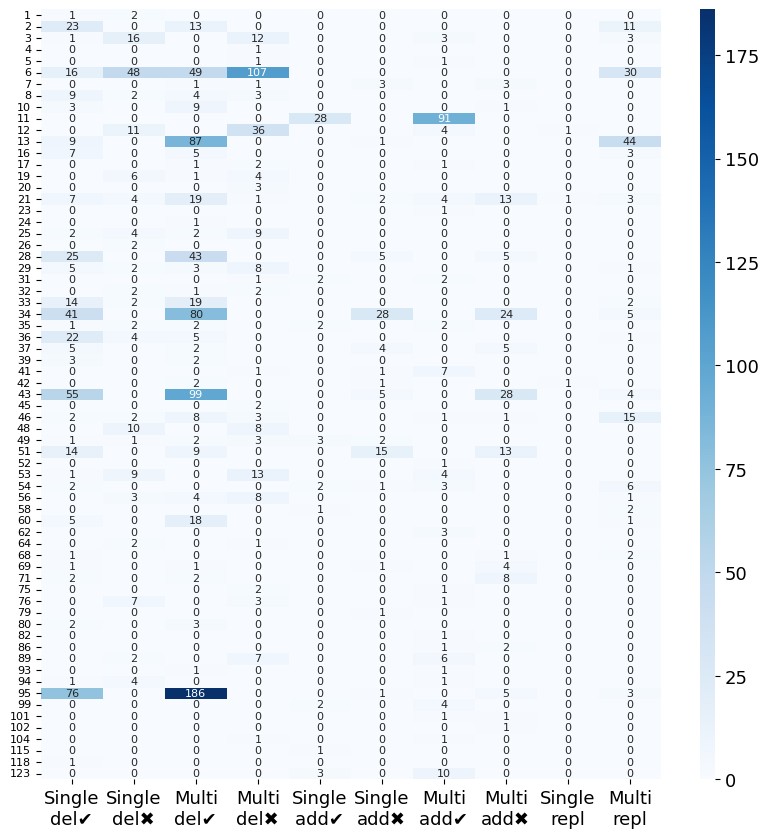

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import emoji

#----附加
# freq_single_add_right = count_frequencies(mapped_single_add_right)
# freq_single_add_wrong = count_frequencies(mapped_single_add_wrong)
# freq_single_replace = count_frequencies(mapped_single_replace)
# freq_multi_add_right = count_frequencies(mapped_multi_add_right)
# freq_multi_add_wrong = count_frequencies(mapped_multi_add_wrong)
# freq_multi_replace = count_frequencies(mapped_multi_replace)
#------

custom_cmap = sns.color_palette("Blues", as_cmap=True) 
# xticklabels = ["Single,del✔️", "Single,del✖", "Multi,del✔️", "Multi,del✖"]
xticklabels = ["Single,del✔️", "Single,del✖", "Multi,del✔️", "Multi,del✖",
               "Single,add✔️", "Single,add✖", "Multi,add✔️", "Multi,add✖",
               "Single,repl", "Multi,repl"
               ]
xticklabels = [label.replace(",", "\n") for label in xticklabels]  # 使用换行符分割单词


# 获取所有药物的排名
# all_ranks = sorted(set(freq_single_del_right.keys())
#                    .union(set(freq_single_del_wrong.keys()))
#                    .union(set(freq_multi_del_right.keys()))
#                    .union(set(freq_multi_del_wrong.keys()))
#                    )
all_ranks = sorted(set(freq_single_del_right.keys())
                   .union(set(freq_single_del_wrong.keys()))
                   .union(set(freq_multi_del_right.keys()))
                   .union(set(freq_multi_del_wrong.keys()))
                   .union(set(freq_single_add_right.keys()))
                   .union(set(freq_single_add_wrong.keys()))
                   .union(set(freq_multi_add_right.keys()))
                   .union(set(freq_multi_add_wrong.keys()))
                   .union(set(freq_single_replace.keys()))
                   .union(set(freq_multi_replace.keys()))
                   )


# 创建一个矩阵，将每个药物的正确和错误数量放入矩阵
matrix = []
for rank in all_ranks:
    single_del_right_count = freq_single_del_right.get(rank, 0)
    single_del_wrong_count = freq_single_del_wrong.get(rank, 0)
    multi_del_right_count = freq_multi_del_right.get(rank, 0)
    multi_del_wrong_count = freq_multi_del_wrong.get(rank, 0)
    #------
    single_add_right_count = freq_single_add_right.get(rank, 0)
    single_add_wrong_count = freq_single_add_wrong.get(rank, 0)
    multi_add_right_count = freq_multi_add_right.get(rank, 0)
    multi_add_wrong_count = freq_multi_add_wrong.get(rank, 0)
    single_replace_count = freq_single_replace.get(rank, 0)
    multi_replace_count = freq_multi_replace.get(rank, 0)
    #------
    matrix.append([single_del_right_count, single_del_wrong_count, multi_del_right_count, multi_del_wrong_count,
                   single_add_right_count, single_add_wrong_count, multi_add_right_count, multi_add_wrong_count,
                   single_replace_count, multi_replace_count
                   ])

# 转换为NumPy数组
matrix = np.array(matrix)

# 绘制热力图
plt.figure(figsize=(10, 10))
ax = sns.heatmap(matrix, annot=True, fmt='d', 
            cmap = custom_cmap, 
            xticklabels=xticklabels, 
            yticklabels=all_ranks, 
            annot_kws={"size": 8},  # 让色块内的字体变小
            cbar_kws={"aspect": 50},  # 缩小右侧颜色图例
            cbar=True)
plt.xticks(fontsize=13)
plt.yticks(fontsize=8)
# 调整 colorbar（右侧颜色图例）的字体大小
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13)  # colorbar 字体变小
# 设置图形标题
# plt.title('Heatmap of Correct vs Incorrect Deletions by Drug Rank')
# 显示图形
plt.show()


In [38]:
import pandas as pd
import numpy as np

# 首先确定完整的 ranks 范围（假设是 1 到 11）
all_ranks_complete = range(1, 124)  # 1到11

# 创建一个全零的完整 DataFrame
full_df = pd.DataFrame(0, 
                      index=all_ranks_complete, 
                      columns=xticklabels,
                      dtype=int)

# 用现有数据更新这个完整 DataFrame
full_df.update(df)

# 现在导出，确保所有 ranks 都存在
full_df.to_csv('complete_heatmap_data.csv', index=True, index_label='Rank')

In [ ]:

import matplotlib.pyplot as plt
from collections import Counter

numbers = list(freq_single_del_right.keys())
counts = list(freq_single_del_right.values())

# 绘制柱状图
plt.figure(figsize=(20, 2))
plt.bar(numbers, counts, color='skyblue')

# 添加标题和标签
# plt.title("Frequency of Numbers in 'Single Del Wrong'", fontsize=14)
plt.xlabel("Frequency Rank", fontsize=16)
plt.ylabel("Count", fontsize=16)

# 显示数值标签
for i, v in enumerate(counts):
    plt.text(numbers[i], v + 0.05, str(v), ha='center', fontsize=10)
plt.xticks(fontsize=16)
plt.xlim(right=125)  # 设置x轴的最大值为125

# 显示图表
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 将频率结果转换为矩阵形式（这里只是一个简单的例子）
data = np.zeros((1, 125))  # 假设最多数字为4
for num, count in freq_single_del_wrong.items():
    data[0, num - 1] = count  # 通过数字减1来定位位置

# 绘制热力图
plt.figure(figsize=(20, 0.5))
sns.heatmap(data, annot=False, cmap='Blues', cbar_kws={'label': 'Count'}, yticklabels=[])

# 添加标题和标签
# plt.title("Heatmap of Frequency in 'Single Del Wrong'", fontsize=14)
plt.xlabel("Frequency Rank", fontsize=16)

# 显示图表
plt.show()


# 结果绘图

### 结果统计

In [ ]:
#基础的流程-------------
import json
rag_pred_path = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-21_analyze_rag_mimic3.json",  
             "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-26_analyze_100-200_rag_mimic3.json", 
             "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-03_analyze_200-600_rag_mimic3.json"]
pure_pred_path = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-18_pure_mimic3.json", 
                  "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-07_pure-100-600_mimic3.json"]
# ja, avg_p, avg_r, avg_f1, ddi 
pure_res_final = evaluate_jsonlines(pure_pred_path, ehr_tokenizer, threshold=0.5, med_num = "final")
res_first = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "first")
res_second = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "second")
res_final = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "final")

print("pure:", pure_res_final)
print("first_node:", res_first)
print("second_node:", res_second)
print("third_node:", res_final)
#----------------------
#分析分组和不分的区别---------------------
rag_pred_path = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-21_analyze_rag_mimic3.json", 
                 "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-01-26_analyze_100-200_rag_mimic3.json", 
                 "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-03_analyze_200-600_rag_mimic3.json"]
res_first = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "first")
res_single = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "single_discussed")
res_multi = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "multi_discussed")
res_second = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "second")

# print("pure:", pure_res_final)
print("first_node:", res_first)
print("single_discuss:", res_single)
print("multi_discuss:", res_multi)
print("second_node:", res_second)
#----------------------
#替换限制-------------
rag_pred_path = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/find_top_n/2025-01-29_top_30_rag_mimic3.json",
                 "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/find_top_n/2025-01-28_top_30_rag_mimic3.json"]
pure_pred_path = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-08_pure_top_30_mimic3.json", 
                  "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/2025-02-09_pure_top_30_mimic3.json"]
# ja, avg_p, avg_r, avg_f1, ddi 
pure_res_final = evaluate_jsonlines(pure_pred_path, ehr_tokenizer, threshold=0.5, med_num = "final")
res_first = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "first")
res_second = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "second")
res_final = evaluate_jsonlines(rag_pred_path, ehr_tokenizer, threshold=0.5, med_num = "final")

print("pure:", pure_res_final)
print("first_node:", res_first)
print("second_node:", res_second)
print("third_node:", res_final)


### 绘图

In [3]:
# 原始字符串
data_str = """
pure: (0.3712836450044356, 0.5854691773601103, 0.5110959959640582, 0.5222645178334648, 0.0961112836840879)
first_node: (0.37134586334320996, 0.4445554521235892, 0.7278395755838712, 0.529109750838163, 0.07469300919417246)
second_node: (0.32516870443386114, 0.41556812484461253, 0.6258746236279602, 0.47997372748645256, 0.06292583899003996)
third_node: (0.322834493305361, 0.41551917827022544, 0.6171191255989362, 0.4769001181998334, 0.06290015488275277)
"""

data_str = """
first_node: (0.37134586334320996, 0.4445554521235892, 0.7278395755838712, 0.529109750838163, 0.07469300919417246)
single_discuss: (0.3315999981669895, 0.41764562914844383, 0.6468155232854466, 0.48721726641076196, 0.06633203351862607)
multi_discuss: (0.3383471123294379, 0.4258830115064989, 0.6531862010192332, 0.4945296604221902, 0.06404510794939963)
second_node: (0.32516870443386114, 0.41556812484461253, 0.6258746236279602, 0.47997372748645256, 0.06292583899003996)
"""

data_str = """
pure: (0.3974674812913043, 0.6209509319588966, 0.5438605560596536, 0.5515678802306786, 0.09100957625330346)
first_node: (0.4274764578184745, 0.5438423018724098, 0.6932902728792899, 0.5860947357233168, 0.08207131079046032)
second_node: (0.37118075431661607, 0.5211413336843795, 0.5860972784139856, 0.5287695686379322, 0.06650155723857355)
third_node: (0.37002685464797247, 0.5211229215271921, 0.5857289349996438, 0.527289737005154, 0.0681968040273613)
"""

#------待删
data_str = """
first_node: (0.36384148139119715, 0.4393553747347178, 0.6929362820713111, 0.5194325620908806, 0.0746787668037827)
second_node: (0.27992926326389794, 0.38790933676106176, 0.49078447563038474, 0.4179926805733572, 0.09019607843137255)
third_node: (0.2788139976749482, 0.41359982801132533, 0.48172686657277564, 0.41604877850344846, 0.08657123381049761)"""

data_str = """
initial: (0.31557685493250653, 0.3445926901164544, 0.8392529028504678, 0.4685317820219094, 0.06577232984741985)
revised_single: (0.2855139492539692, 0.33076265424627216, 0.7153529281086703, 0.43369263778032846, 0.055699357683827055)
revised_multi: (0.2816988995437978, 0.3332016303059716, 0.702328407809471, 0.43018667546027756, 0.05403880304715118)
revised: (0.27971470164357015, 0.33496880278470037, 0.67584129970456, 0.4272973007077859, 0.051689114323000024)
voted: (0.2571982913360293, 0.35527600127565956, 0.5482809267887367, 0.3991244505280085, 0.05162398593968762)
control_single_revised: (0.27871586258816067, 0.33961505881400555, 0.6565396703461082, 0.4254177234978095, 0.050821041278943595)
control_single_voted: (0.2433834342122249, 0.35396007665003554, 0.491831181128237, 0.379314335944398, 0.05656119518258393)
control_multi_revised: (0.2815053208807374, 0.33537244630520646, 0.6870783774819389, 0.4297343408318161, 0.051760422840140784)
control_multi_voted: (0.23989566936003218, 0.35725638222424444, 0.4745430004037165, 0.3744296860497323, 0.055536267664493565)

"""

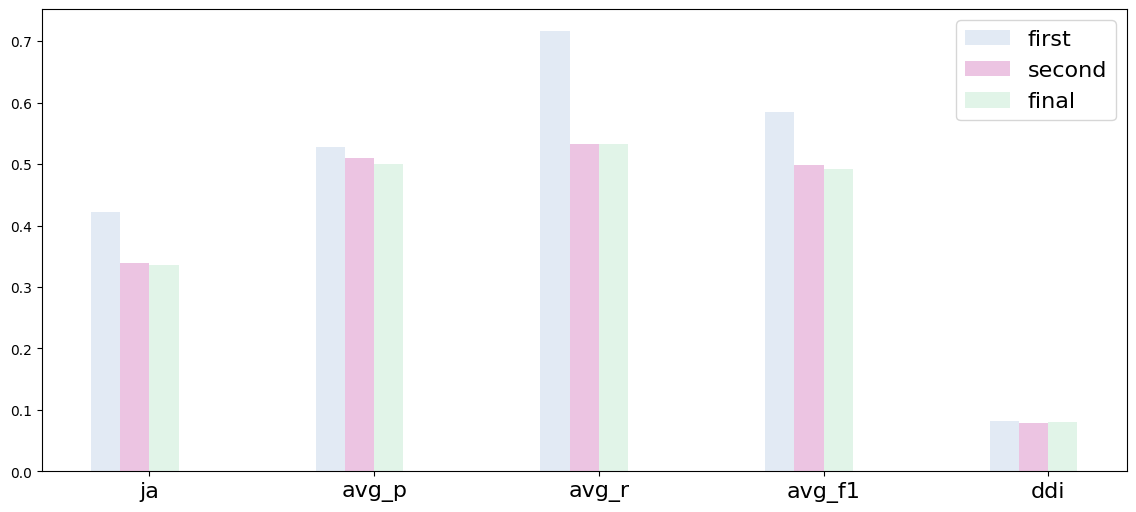

In [15]:
import re
import numpy as np
import matplotlib.pyplot as plt



# 解析字符串，提取数据
pattern = r"(\w+): \(([^)]+)\)"
matches = re.findall(pattern, data_str)
data_dict = {name: list(map(float, values.split(", "))) for name, values in matches}

labels = ["ja", "avg_p", "avg_r", "avg_f1", "ddi"]
methods = list(data_dict.keys())
data = np.array(list(data_dict.values()))

# 自定义一组浅色系的颜色（你可以根据需要修改这些颜色）
# colors = ["#A1C9F4", "#C2E699", "#FACD8A", "#F1A9A0"] e1f4e8 ecc4e2 E7DDFF
colors = ["#E2EAF4", "#ecc4e2", "#e1f4e8", "#E7DDFF","#9cdfff", "#669fcb", ]

x = np.arange(len(labels))
width = 0.13

# fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(14, 6))
for i, method in enumerate(methods):
    ax.bar(x + i * width, data[i], width, label=method, color=colors[i])

ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(labels, fontsize=16)
# ax.set_ylabel("Score", fontsize=12)
# ax.set_title("Comparison of Different Methods", fontsize=14)
ax.legend(fontsize=16)

plt.show()


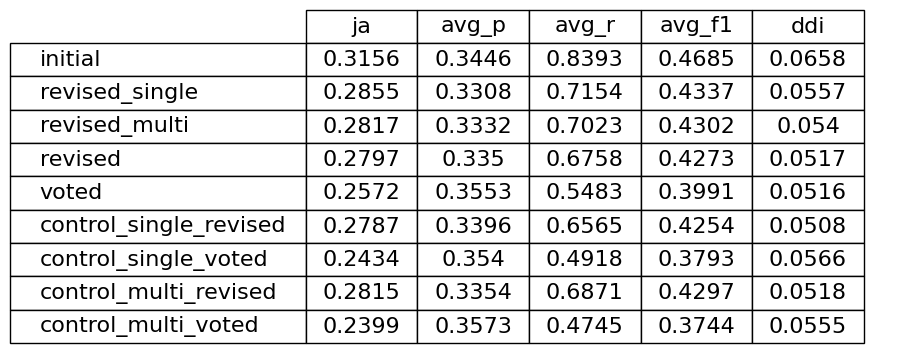

In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# 使用正则表达式解析字符串，提取数据
pattern = r"(\w+): \(([^)]+)\)"
matches = re.findall(pattern, data_str)
data_dict = {name: list(map(float, values.split(", "))) for name, values in matches}

# 指定每个数据对应的指标名称
labels = ["ja", "avg_p", "avg_r", "avg_f1", "ddi"]

# 将数据转换为 DataFrame，方法名称作为行索引，指标作为列
df = pd.DataFrame.from_dict(data_dict, orient='index', columns=labels)
# 可以选择将数据保留一定的小数位
df = df.round(4)

# 创建一个图形，隐藏坐标轴，仅显示表格
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

# 将 DataFrame 数据添加为表格，显示在图形中
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 rowLabels=df.index,
                 cellLoc='center',
                 loc='center')

# 你可以设置表格字体大小、行高等参数（可选）
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(0.9, 2.0)

plt.show()


## 3. 不同模型召集的MDT专家的相似度对比

In [1]:
rag_pred_path_qwen = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_qwen_all_node2_rag_mimic3.json"]
rag_pred_path_ds = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_deepseek_all_node2_rag_mimic3.json"]
rag_pred_path_mistral = ["/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_mistral_all_node2_rag_mimic3.json"]
rag_pred_path_gpt = ['/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_gpt_all_node2_rag_mimic3.json']
#MDT_list， patient_condition
# 计算相似度规则：比如针对一条数据，deepaseek提出“['Primary Care Physician (PCP)', 'Hematologist', 'Urologist or Infectious Disease Specialist', 'Pharmacist', 'Dietitian/Nutritionist', 'Geriatrician (Optional)']", mistral提出“['Primary Care Physician (PCP)', 'Hematologist', 'Urologist or Infectious Disease Specialist', 'Pharmacist', 'Dietitian', 'Geriatrician]”,先要寻找它们之间完全相同的项，记录相似度（应该是1），再将剩下的['Dietitian/Nutritionist', 'Geriatrician (Optional)']和[ 'Dietitian', 'Geriatrician']进行相似度计算，而且也不要拼接，而是每项和每项对比，取最高的相似度，最终进行加权求和，比如这里剩下的就会得到'Dietitian/Nutritionist'和'Dietitian'有一个较高的相似度， 'Geriatrician (Optional)'和'Geriatrician'有一个较高的相似度,最终可以认为这两个模型得到的专家是几乎一致的

In [23]:
#计算相似度
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast

# 1. 读取 JSON 文件
def load_mdt_lists(file_path):
    """从 JSON 文件中提取 patient_condition 和 MDT_list"""
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return {entry["patient_condition"]: entry["MDT_list"] for entry in data}

# 2. 读取每个模型的结果
rag_pred_path_qwen = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_qwen_all_node2_rag_mimic3.json"
rag_pred_path_ds = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_deepseek_all_node2_rag_mimic3.json"
rag_pred_path_mistral = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_mistral_all_node2_rag_mimic3.json"
rag_pred_path_gpt = '/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_gpt_all_node2_rag_mimic3.json'

mdt_qwen = load_mdt_lists(rag_pred_path_qwen)
mdt_ds = load_mdt_lists(rag_pred_path_ds)
mdt_mistral = load_mdt_lists(rag_pred_path_mistral)
mdt_gpt = load_mdt_lists(rag_pred_path_gpt)

# 3. 获取所有 patient_condition，确保对齐
common_conditions = set(mdt_qwen.keys()) & set(mdt_ds.keys()) & set(mdt_mistral.keys()) & set(mdt_gpt.keys())

# 4. 计算相似度函数
def compute_mdt_similarity(list1, list2, threshold=0.75):
    # print("1", list1)
    # print("2", list2)
    list1 = [item.lower() for item in list1]
    list2 = [item.lower() for item in list2]
    common = set()
    common_num = 0
    
    # 完全匹配的项，考虑子字符串匹配&Hepatology=Hepatologist
    for item1 in list1:
        for item2 in list2:
            if item1 == item2 or item1 in item2 or item2 in item1 or item1[:5] == item2[:5]:
                common.add(item1)
                common.add(item2)  # 确保两个项都加入到common
                common_num += 1
                break
    similarity_score = common_num

    # 获取剩余需要匹配的项
    remaining1 = list(set(list1) - common)
    remaining2 = list(set(list2) - common)

    if not remaining1 or not remaining2:  # 如果有一个列表为空，直接返回已有匹配度
        return similarity_score  / max(len(list1), len(list2))

    # 计算 TF-IDF 余弦相似度
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(remaining1 + remaining2)
    similarity_matrix = cosine_similarity(tfidf_matrix[:len(remaining1)], tfidf_matrix[len(remaining1):])
    if similarity_matrix.size > 0:
        best_similarities_1 = similarity_matrix.max(axis=1)  
        best_similarities_2 = similarity_matrix.max(axis=0)  
        # 过滤大于 threshold 的项，将其设为 1
        best_similarities_1[best_similarities_1 > threshold] = 1.0
        best_similarities_2[best_similarities_2 > threshold] = 1.0
    else:
        best_similarities_1 = np.array([])
        best_similarities_2 = np.array([])
    similarity_score += (best_similarities_1.mean() + best_similarities_2.mean())    # 计算加权得分
    # 归一化处理
    # print(similarity_score, min(len(list1), len(list2)))
    similarity_score /= min(len(list1), len(list2))
    return similarity_score

# 5. 计算不同模型的 MDT 相似度
similarities_qwen_ds = []
similarities_qwen_mistral = []
similarities_ds_mistral = []
similarities_qwen_gpt = []
similarities_ds_gpt = []
similarities_mistral_gpt = []
uniq = {}
qwends_common = []

for condition in common_conditions:
    sim_qwen_ds = compute_mdt_similarity(mdt_qwen[condition], mdt_ds[condition])
    sim_qwen_mistral = compute_mdt_similarity(mdt_qwen[condition], mdt_mistral[condition])
    sim_ds_mistral = compute_mdt_similarity(mdt_ds[condition], mdt_mistral[condition])
    sim_ds_gpt = compute_mdt_similarity(mdt_ds[condition], mdt_gpt[condition])
    sim_qwen_gpt = compute_mdt_similarity(mdt_qwen[condition], mdt_gpt[condition])
    sim_mistral_gpt = compute_mdt_similarity(mdt_mistral[condition], mdt_gpt[condition])

    similarities_qwen_ds.append(sim_qwen_ds)
    similarities_qwen_mistral.append(sim_qwen_mistral)
    similarities_ds_mistral.append(sim_ds_mistral)
    similarities_qwen_gpt.append(sim_qwen_gpt)
    similarities_ds_gpt.append(sim_ds_gpt)
    similarities_mistral_gpt.append(sim_mistral_gpt)

# 6. 计算平均相似度
avg_sim_qwen_ds = np.mean(similarities_qwen_ds)
avg_sim_qwen_mistral = np.mean(similarities_qwen_mistral)
avg_sim_ds_mistral = np.mean(similarities_ds_mistral)
avg_sim_qwen_gpt = np.mean(similarities_qwen_gpt)
avg_sim_ds_gpt = np.mean(similarities_ds_gpt)
avg_sim_mistral_gpt = np.mean(similarities_mistral_gpt)

# 7. 输出结果
print(f"Qwen vs. DeepSeek 平均余弦相似度: {avg_sim_qwen_ds:.4f}")
print(f"Qwen vs. Mistral 平均余弦相似度: {avg_sim_qwen_mistral:.4f}")
print(f"DeepSeek vs. Mistral 平均余弦相似度: {avg_sim_ds_mistral:.4f}")
print(f"qwen vs. gpt 平均余弦相似度: {avg_sim_qwen_gpt:.4f}")
print(f"ds vs. gpt 平均余弦相似度: {avg_sim_ds_gpt:.4f}")
print(f"mistral vs. gpt 平均余弦相似度: {avg_sim_mistral_gpt:.4f}")



Qwen vs. DeepSeek 平均余弦相似度: 0.8009
Qwen vs. Mistral 平均余弦相似度: 0.7704
DeepSeek vs. Mistral 平均余弦相似度: 0.7787
qwen vs. gpt 平均余弦相似度: 0.8170
ds vs. gpt 平均余弦相似度: 0.7925
mistral vs. gpt 平均余弦相似度: 0.8314


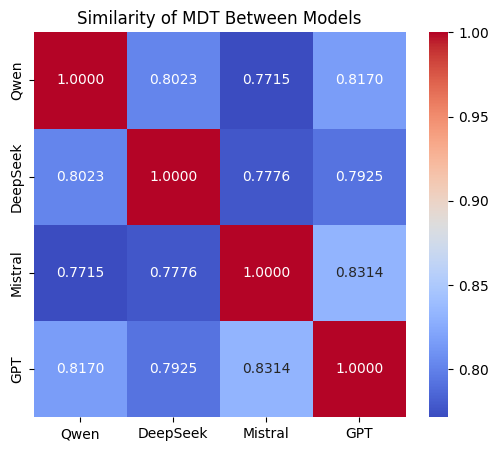

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 示例数据：四个组之间的两两相似度
groups = ["Qwen", "DeepSeek", "Mistral", "GPT"]
similarity_matrix = np.array([
    [1.00, 0.8023, 0.7715, 0.8170],
    [0.8023, 1.00, 0.7776, 0.7925],
    [0.7715, 0.7776, 1.00, 0.8314],
    [0.8170, 0.7925, 0.8314, 1.00]
])

# 画热力图
plt.figure(figsize=(6, 5))
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", xticklabels=groups, yticklabels=groups, fmt=".4f")

plt.title("Similarity of MDT Between Models")
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(similarity_matrix, index=groups, columns=groups)

# 使用 Seaborn 样式的表格
styled_df = df.style.background_gradient(cmap="coolwarm").set_precision(2)
styled_df


In [24]:
#计算生成MDT专家的平均个数------
from utils import multi_test_anova
def compute_mdt_num(list1):
    if type(list1)==list:
        return len(list1)
    else:
        list1 = ast.literal_eval(list1)
        return len(list1)

qwen_mdt_nums = []
ds_mdt_nums = []
mistral_mdt_nums = []
gpt_mdt_nums = []
for condition in common_conditions:
    qwen_mdt_num = compute_mdt_num(mdt_qwen[condition])
    ds_mdt_num = compute_mdt_num(mdt_ds[condition])
    mistral_mdt_num = compute_mdt_num(mdt_mistral[condition])
    gpt_mdt_num = compute_mdt_num(mdt_gpt[condition])

    qwen_mdt_nums.append(qwen_mdt_num)
    ds_mdt_nums.append(ds_mdt_num)
    mistral_mdt_nums.append(mistral_mdt_num)
    gpt_mdt_nums.append(gpt_mdt_num)
num_avg_qwen, num_std_qwen = multi_test_anova(qwen_mdt_nums)
num_avg_ds, num_std_ds = multi_test_anova(ds_mdt_nums)
num_avg_mistral, num_std_mistral = multi_test_anova(mistral_mdt_nums)
num_avg_gpt, num_std_gpt = multi_test_anova(gpt_mdt_nums)
# print(avg_qwen_mdt_nums, avg_ds_mdt_nums, avg_mistral_mdt_nums)
print(num_avg_qwen, num_std_qwen)
print(num_avg_ds, num_std_ds)
print(num_avg_mistral, num_std_mistral)
print(num_avg_gpt, num_std_gpt)

10.672282608695653 0.043887341811352974
10.209782608695651 0.0463838875942431
11.531521739130435 0.03896780819618111
9.639130434782608 0.04275554220699326


In [7]:
import pandas as pd

# 将数据转换为DataFrame
data = pd.DataFrame({
    'value': qwen_mdt_nums + ds_mdt_nums + mistral_mdt_nums + gpt_mdt_nums,
    'group': ['qwen']*len(qwen_mdt_nums) + ['ds']*len(ds_mdt_nums) + 
             ['mistral']*len(mistral_mdt_nums) + ['gpt']*len(gpt_mdt_nums)
})

In [8]:
from scipy.stats import kruskal
import scikit_posthocs as sp

# 1. Kruskal-Wallis检验
h_stat, kw_p = kruskal(qwen_mdt_nums, ds_mdt_nums,
                      mistral_mdt_nums, gpt_mdt_nums)
print(f"Kruskal-Wallis检验p值: {kw_p:.4f}")

# 2. 若检验显著，进行Dunn事后检验
if kw_p < 0.05:
    dunn = sp.posthoc_dunn(data, val_col='value', group_col='group', 
                          p_adjust='bonferroni')
    print("\nDunn事后检验（校正后p值）:")
    print(dunn)

Kruskal-Wallis检验p值: 0.0000

Dunn事后检验（校正后p值）:
                   ds           gpt       mistral          qwen
ds       1.000000e+00  5.237098e-04  8.499560e-16  1.087913e-03
gpt      5.237098e-04  1.000000e+00  2.193029e-33  1.054920e-13
mistral  8.499560e-16  2.193029e-33  1.000000e+00  3.717075e-05
qwen     1.087913e-03  1.054920e-13  3.717075e-05  1.000000e+00


In [9]:
# print(data.groupby('group')['value'].describe(percentiles=[.25, .5, .75]))
import pandas as pd

# 合并所有数据（假设data是之前创建的DataFrame）
all_values = data['value']

# 计算整体描述统计
overall_stats = all_values.describe(percentiles=[.25, .5, .75])
print("所有数据合并后的描述统计：")
print(overall_stats)

所有数据合并后的描述统计：
count    1844.000000
mean       10.504881
std         2.327145
min         1.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: value, dtype: float64


In [34]:
print(len(qwen_mdt_nums), qwen_mdt_nums[0])

461 13


In [4]:
import matplotlib.font_manager as fm
# sorted([f.name for f in fm.fontManager.ttflist if 'Times' in f.name])
sorted([f.name for f in fm.fontManager.ttflist])

['AR PL UKai CN',
 'AR PL UMing CN',
 'Abyssinica SIL',
 'Ani',
 'AnjaliOldLipi',
 'C059',
 'C059',
 'C059',
 'C059',
 'Chandas',
 'Chilanka',
 'D050000L',
 'DejaVu Math TeX Gyre',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Dhurjati',
 'Droid Sans Fallback',
 'Dyuthi',
 'FreeMono',
 'FreeMono',
 'FreeMono',
 'FreeMono',
 'FreeSans',
 'FreeSans',
 'FreeSans',
 'FreeSans',
 'FreeSerif',
 'FreeSerif',
 'FreeSeri

/tmp/ipykernel_2162646/1554961574.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


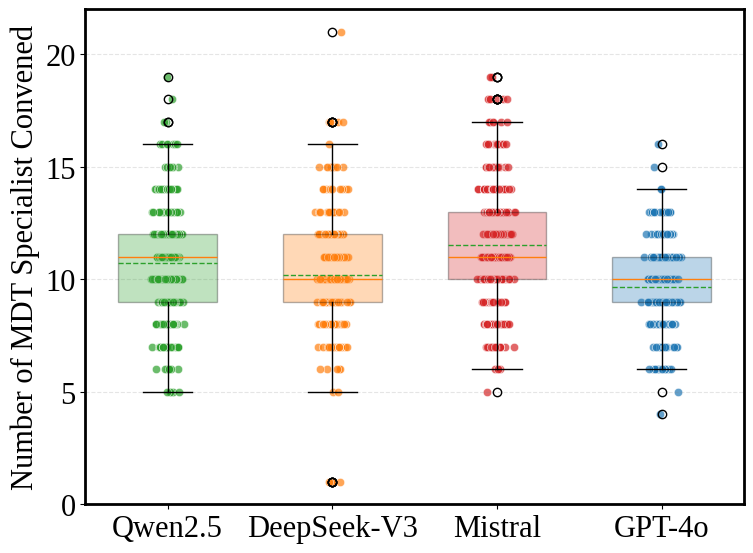

In [27]:
#箱线图+散点图
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams  # 导入全局字体设置模块

# === 1. 全局设置Times New Roman字体 ===
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Liberation Serif', 'DejaVu Serif', 'Nimbus Roman', 'STIXGeneral'] 
rcParams['font.size'] = 22  
# 准备数据
data = [qwen_mdt_nums,
        ds_mdt_nums,
        mistral_mdt_nums,
    gpt_mdt_nums,
]
labels = ['Qwen2.5', 'DeepSeek-V3', 'Mistral', 'GPT-4o']

# 初始化画布
plt.figure(figsize=(8, 6))

# 绘制箱线图
box = plt.boxplot(
    data,
    labels=labels,
    patch_artist=True,
    showmeans=True,  # 显示均值
    meanline=True,   # 均值用线表示
    widths=0.6
)

# 自定义样式
colors = ['#2ca02c', '#ff7f0e', '#d62728', '#1f77b4']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)

# 叠加散点图（显示所有数据点）
for i, model_data in enumerate(data):
    x = np.random.normal(i+1, 0.04, size=len(model_data))  # 添加轻微抖动防止重叠
    plt.scatter(x, model_data, color=colors[i], alpha=0.7, edgecolors='w', linewidth=0.5)

# 添加标注
# plt.title('MDT专家召集数量分布', fontsize=14)
plt.ylabel('Number of MDT Specialist Convened', fontsize=22)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(False)
plt.xticks(fontsize=22)  # 横坐标刻度字体
plt.yticks(fontsize=22)  # 纵坐标刻度字体

plt.tight_layout()
# 在plt.show()前添加这些美化代码
plt.gca().spines['bottom'].set_linewidth(2)  # 加粗下边框
plt.gca().spines['left'].set_linewidth(2)    # 加粗左边框
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
# 添加浅色网格线
plt.grid(axis='y', linestyle='--', alpha=0.2, color='gray')

# 调整边距
plt.tight_layout()
plt.show()

In [ ]:
##模型独特专家
import json

# 1. 读取 JSON 文件
def load_mdt_lists(file_path):
    """从 JSON 文件中提取 MDT_list"""
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return [entry["MDT_list"] for entry in data]  # 只关心 MDT_list

# 2. 读取每个模型的结果
rag_pred_path_qwen = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_qwen_all_node2_rag_mimic3.json"
rag_pred_path_ds = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_deepseek_all_node2_rag_mimic3.json"
rag_pred_path_mistral = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_mistral_all_node2_rag_mimic3.json"
rag_pred_path_gpt = "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/output/final_res/process_common/common_entries_gpt_all_node2_rag_mimic3.json"

mdt_qwen = load_mdt_lists(rag_pred_path_qwen)
mdt_ds = load_mdt_lists(rag_pred_path_ds)
mdt_mistral = load_mdt_lists(rag_pred_path_mistral)
mdt_gpt = load_mdt_lists(rag_pred_path_gpt)

# 3. 合并所有专家
all_experts_qwen = set([expert for experts in mdt_qwen for expert in experts])
all_experts_ds = set([expert for experts in mdt_ds for expert in experts])
all_experts_mistral = set([expert for experts in mdt_mistral for expert in experts])
all_experts_gpt = set([expert for experts in mdt_gpt for expert in experts])

# 4. 判断专家是否相同的规则
def are_experts_equal(expert1, expert2):
    expert1 = expert1.lower()
    expert2 = expert2.lower()
    return expert1 == expert2 or expert1 in expert2 or expert2 in expert1 or expert1[:4] == expert2[:4]

# 5. 计算每个模型的独特专家
uniq_qwen = set()
uniq_ds = set()
uniq_mistral = set()
uniq_gpt = set()

# 比较所有专家，找出各模型独特的专家
for expert_qwen in all_experts_qwen:
    if not any(are_experts_equal(expert_qwen, expert) for expert in all_experts_ds) and \
       not any(are_experts_equal(expert_qwen, expert) for expert in all_experts_mistral) and \
        not any(are_experts_equal(expert_qwen, expert) for expert in all_experts_gpt):
        uniq_qwen.add(expert_qwen)

for expert_ds in all_experts_ds:
    if not any(are_experts_equal(expert_ds, expert) for expert in all_experts_qwen) and \
       not any(are_experts_equal(expert_ds, expert) for expert in all_experts_mistral) and \
       not any(are_experts_equal(expert_ds, expert) for expert in all_experts_gpt):
        uniq_ds.add(expert_ds)

for expert_mistral in all_experts_mistral:
    if not any(are_experts_equal(expert_mistral, expert) for expert in all_experts_qwen) and \
       not any(are_experts_equal(expert_mistral, expert) for expert in all_experts_ds) and \
        not any(are_experts_equal(expert_mistral, expert) for expert in all_experts_gpt):
        uniq_mistral.add(expert_mistral)

for expert_gpt in all_experts_gpt:
    if not any(are_experts_equal(expert_gpt, expert) for expert in all_experts_qwen) and \
       not any(are_experts_equal(expert_gpt, expert) for expert in all_experts_ds) and \
        not any(are_experts_equal(expert_gpt, expert) for expert in all_experts_mistral):
        uniq_gpt.add(expert_gpt)




In [2]:
# 6. 输出每个模型的独特专家
print(f"Qwen 独特专家: {uniq_qwen}")
print(f"DeepSeek 独特专家: {uniq_ds}")
print(f"Mistral 独特专家: {uniq_mistral}")
print(f"gpt 独特专家: {uniq_gpt}")

Qwen 独特专家: {'Research Coordinator'}
DeepSeek 独特专家: {'ayer', 'Pancreatologist', 'Audiology', 'nik', 'Ethics Committee', 'eren', 'woods'}
Mistral 独特专家: {'Andrologist', 'Down Syndrome Specialist', 'Sexual Health Specialist', 'Epileptologist', 'Oral Medicine Specialist', 'Poison Control', 'Otorhinolaryngologist', 'Anaesthesiologist', 'Dialysis Support Team', 'Family Medicine Physician'}
gpt 独特专家: {'Obesity Medicine', 'Patient Education/Support Services', 'Phlebologist'}


In [142]:
print(similarities_qwen_ds)
median_similarity = np.median(similarities_qwen_ds) #中位数
print(median_similarity)
# 计算 75th Percentile
percentile_75 = np.percentile(similarities_qwen_ds, 75)
print("75th Percentile:", percentile_75)

# 计算 90th Percentile
percentile_90 = np.percentile(similarities_qwen_ds, 90)
print("90th Percentile:", percentile_90)

[1.0, 0.75, 0.875, 0.8333333333333334, 0.7, 0.9275073753932387, 0.9302745643732024, 0.7272727272727273, 0.8333333333333334, 0.9090909090909091, 0.8, 0.8333333333333334, 0.9090909090909091, 0.6666666666666666, 0.9, 0.8333333333333334, 0.6, 0.7, 0.7, 0.8020346485526532, 0.6, 0.8181818181818182, 0.7272727272727273, 0.5, 0.9751491309434233, 0.7701277731245804, 0.7807417151588795, 0.65, 0.8181818181818182, 0.7142857142857143, 0.8414998833947098, 0.6566038130408127, 0.75, 0.75, 1.0, 0.8333333333333334, 0.0, 0.7637856086261802, 1.036506169300257, 0.7777777777777778, 0.7142857142857143, 0.8259288506222446, 0.875, 0.9044877948346539, 0.9, 0.8, 0.7847551475924451, 0.8333333333333334, 0.972784459354971, 0.9166666666666666, 0.875, 0.875, 0.6, 0.875, 0.625, 0.9, 0.875, 0.9, 0.8, 0.7132398005217656, 0.6666666666666666, 1.0391398219479988, 0.9, 0.9241829309864059, 0.75, 0.8571428571428571, 0.8333333333333334, 0.8, 0.875, 0.875, 0.9, 0.8888888888888888, 1.0, 0.7272727272727273, 0.7142857142857143, 0.9

In [162]:
list1 = ["Primary Care Physician (PCP)", "Hematologist", "Urologist or Infectious Disease Specialist", "Dietitian/Nutritionist", "Geriatrician (Optional)"]
list2 = ["Primary Care Physician (PCP)", "Hematologist", "Urologist or Infectious Disease Specialist", "Pharmacist", "Dietitian", "Geriatrician"]

similarity_score = compute_mdt_similarity(list1, list2)
print(similarity_score )


0.8333333333333334


各模型在各维度的均值和标准差:

--- GPT-4o ---
Relevance: 均值 = 4.570, 标准差 = 0.602
Completeness: 均值 = 4.722, 标准差 = 0.539
Redundancy: 均值 = 4.500, 标准差 = 0.628
Factual
Consistency: 均值 = 4.687, 标准差 = 0.506
Multidisciplinary
Value: 均值 = 4.810, 标准差 = 0.393
Harmfulness: 均值 = 4.987, 标准差 = 0.115
Confidence: 均值 = 4.487, 标准差 = 0.649

--- DeepSeek-V3 ---
Relevance: 均值 = 4.580, 标准差 = 0.616
Completeness: 均值 = 4.778, 标准差 = 0.532
Redundancy: 均值 = 4.350, 标准差 = 0.674
Factual
Consistency: 均值 = 4.703, 标准差 = 0.524
Multidisciplinary
Value: 均值 = 4.788, 标准差 = 0.462
Harmfulness: 均值 = 4.970, 标准差 = 0.263
Confidence: 均值 = 4.453, 标准差 = 0.670

--- Qwen2.5 ---
Relevance: 均值 = 4.427, 标准差 = 0.657
Completeness: 均值 = 4.695, 标准差 = 0.602
Redundancy: 均值 = 4.320, 标准差 = 0.674
Factual
Consistency: 均值 = 4.620, 标准差 = 0.574
Multidisciplinary
Value: 均值 = 4.760, 标准差 = 0.443
Harmfulness: 均值 = 4.963, 标准差 = 0.188
Confidence: 均值 = 4.250, 标准差 = 0.697

--- Mistral ---
Relevance: 均值 = 4.413, 标准差 = 0.650
Completeness: 均值 = 4.850, 标准差 = 0.383
Redundancy: 

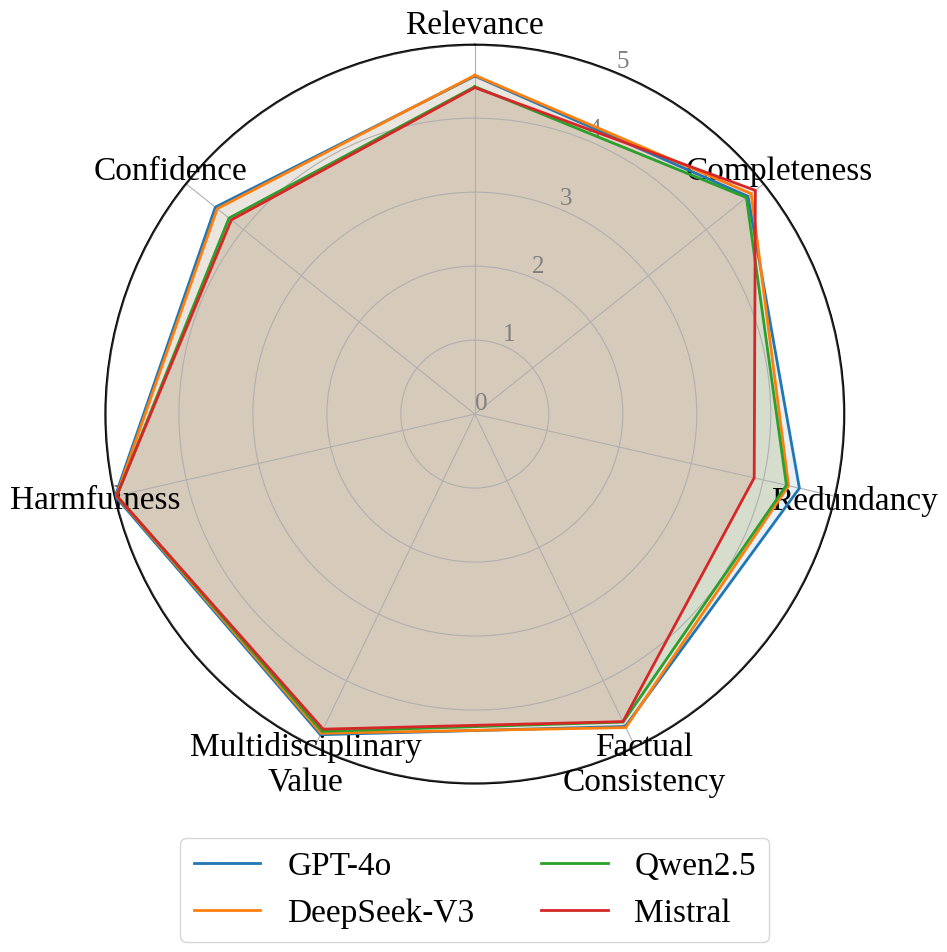

In [31]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Liberation Serif', 'DejaVu Serif', 'Nimbus Roman', 'STIXGeneral'] 
rcParams['font.size'] = 22 

# 定义三个文件路径
file_paths = [
    "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/results/R_MDT_Score.xlsx",
    "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/results/R2__MDT_Score.xlsx",
    "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/results/R3_MDT_Score.xlsx"
]

# 定义模型名称和维度标签
models = ["GPT-4o", "DeepSeek-V3", "Qwen2.5", "Mistral"]
dimensions = ['Relevance', 'Completeness', 'Redundancy', 'Factual\nConsistency', 
              'Multidisciplinary\nValue', 'Harmfulness', 'Confidence']

# 初始化存储结构 - 用于收集所有文件的数据
all_results = {model: {dim: [] for dim in dimensions} for model in models}

# 处理每个文件
for file_path in file_paths:
    # 读取数据
    df = pd.read_excel(file_path, 
                      sheet_name="Chinese",
                      header=None,
                      skiprows=3,
                      usecols="K:N",
                      nrows=100)
    
    # 处理每一行数据
    for row_idx, row in df.iterrows():
        for col_idx, model in enumerate(models):
            cell_value = row.iloc[col_idx]
            
            try:
                # 使用正则表达式提取所有数字
                numbers = re.findall(r"[\d\.]+", str(cell_value))
                values = list(map(float, numbers))
                
                # 验证数据长度
                if len(values) != 7:
                    print(f"警告：文件{file_path} 第{row_idx+4}行 {model} 数据长度异常，已跳过")
                    continue

                # 验证数据大小
                if max(values) > 5:
                    print(f"警告：文件{file_path} 第{row_idx+4}行 {model} 数据大小异常，已跳过")
                    continue
                    
                # 存储到对应维度
                for dim_idx, dim in enumerate(dimensions):
                    all_results[model][dim].append(values[dim_idx])
                    
            except Exception as e:
                print(f"错误：文件{file_path} 第{row_idx+4}行 {model} 数据处理失败 - {str(e)}")
                continue

# 计算均值和标准差
statistics = {model: {} for model in models}
for model in models:
    for dim in dimensions:
        data = all_results[model][dim]
        if data:
            statistics[model][dim] = {
                'mean': np.mean(data),
                'std': np.std(data, ddof=1)  # 样本标准差
            }
        else:
            statistics[model][dim] = {
                'mean': 0,
                'std': 0
            }

# 打印统计结果
print("各模型在各维度的均值和标准差:")
for model in models:
    print(f"\n--- {model} ---")
    for dim in dimensions:
        print(f"{dim}: 均值 = {statistics[model][dim]['mean']:.3f}, 标准差 = {statistics[model][dim]['std']:.3f}")

# 准备雷达图数据（使用均值）
averages = {model: {dim: statistics[model][dim]['mean'] for dim in dimensions} for model in models}

# 绘制雷达图
plt.figure(figsize=(10, 10))
plt.subplot(polar=True)

# 准备雷达图数据
labels = np.array(dimensions)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 闭合图形

# 自定义颜色
model_colors = {
    "GPT-4o": "#1f77b4",  # 蓝色
    "DeepSeek-V3": "#ff7f0e",  # 橙色
    "Qwen2.5": "#2ca02c",  # 绿色
    "Mistral": "#d62728"  # 红色
}

# 为每个模型绘制图形
for model in models:
    values = [averages[model][dim] for dim in dimensions]
    values += values[:1]  # 闭合
    
    # 绘制线条
    plt.plot(angles, values, color=model_colors[model], linewidth=2, label=model)
    # 填充颜色
    plt.fill(angles, values, color=model_colors[model], alpha=0.1)

# 设置标签和标题
plt.xticks(angles[:-1], labels, fontsize=24)
# plt.yticks(np.arange(3.5, 5.1, 0.5), ["3.5", "4", "4.5", "5"], fontsize=18)
# plt.tick_params(axis='y', colors='gray') 
# plt.ylim(3.5, 5)
plt.yticks(np.arange(0, 5.1, 1), ["0", "1", "2","3", "4", "5"], fontsize=18)
plt.tick_params(axis='y', colors='gray') 
plt.ylim(0, 5)
# 调整极坐标参数
plt.gca().set_theta_offset(np.pi / 2)
plt.gca().set_theta_direction(-1)

# 添加图例
plt.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.05),
          ncol=2,
          prop={'size': 24})

# === 新增：加粗最外层圆环 ===
# 获取当前极坐标轴的径向网格线
ax = plt.gca()
gridlines = ax.yaxis.get_gridlines()

# 遍历所有径向网格线，找到最外层的那条（对应y=5）
for line in gridlines:
    if line.get_ydata()[0] == 5:  # 检查是否是最外层圆环
        line.set_linewidth(2.5)    # 加粗线宽
        line.set_color('black')    # 设置为黑色
        line.set_alpha(0.8)       # 适当降低透明度

#——————
# 显示图形
plt.tight_layout()
plt.show()

# Case 结果统计

各模型在各维度的均值和标准差:

--- GPT-4o ---
MDT
Accuracy: 均值 = 3.750, 标准差 = 0.500
MDT
Completeness: 均值 = 4.750, 标准差 = 0.500
Detect
Accuracy: 均值 = 4.750, 标准差 = 0.500
Detect
Completeness: 均值 = 4.750, 标准差 = 0.500
Detect
Explainability: 均值 = 4.250, 标准差 = 0.957
Allocation
Reasonableness: 均值 = 4.250, 标准差 = 0.957
Allocation
Efficiency: 均值 = 4.250, 标准差 = 0.500

--- DeepSeek-V3 ---
MDT
Accuracy: 均值 = 4.250, 标准差 = 0.957
MDT
Completeness: 均值 = 4.750, 标准差 = 0.500
Detect
Accuracy: 均值 = 4.250, 标准差 = 0.500
Detect
Completeness: 均值 = 4.750, 标准差 = 0.500
Detect
Explainability: 均值 = 4.000, 标准差 = 0.816
Allocation
Reasonableness: 均值 = 3.750, 标准差 = 0.500
Allocation
Efficiency: 均值 = 4.250, 标准差 = 0.957

--- Qwen2.5 ---
MDT
Accuracy: 均值 = 4.500, 标准差 = 0.577
MDT
Completeness: 均值 = 4.750, 标准差 = 0.500
Detect
Accuracy: 均值 = 4.500, 标准差 = 0.577
Detect
Completeness: 均值 = 4.750, 标准差 = 0.500
Detect
Explainability: 均值 = 4.500, 标准差 = 0.577
Allocation
Reasonableness: 均值 = 4.500, 标准差 = 0.577
Allocation
Efficiency: 均值 = 4.750, 标准差 = 0.5

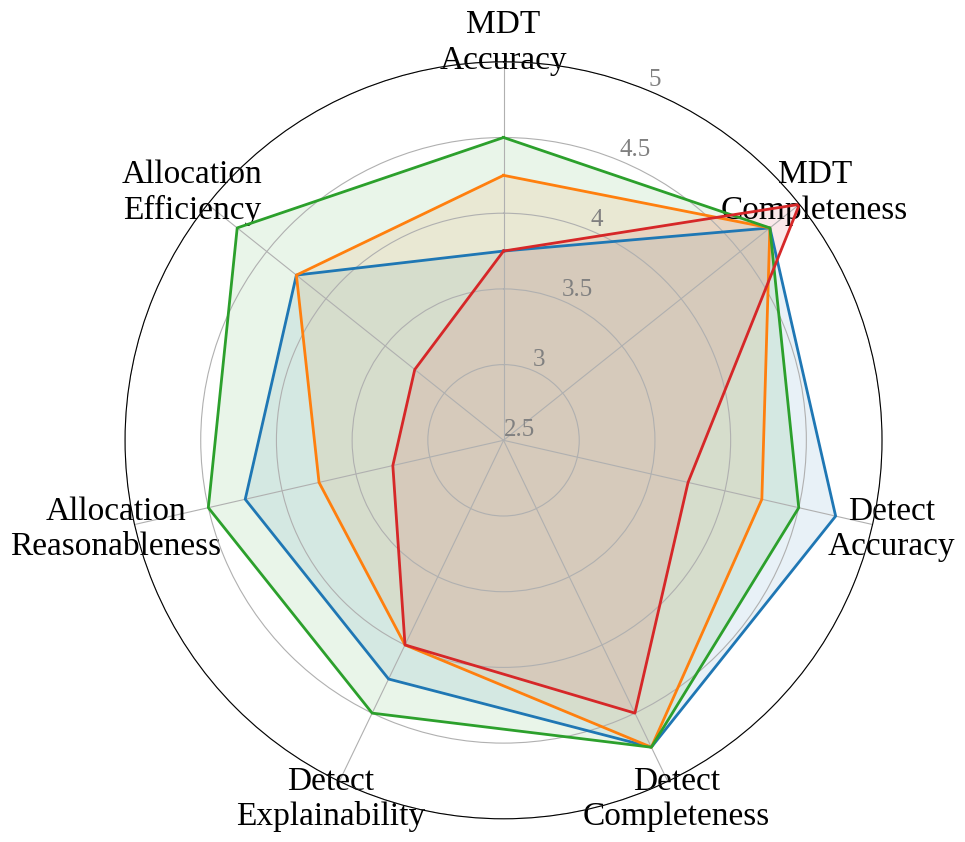

In [9]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Liberation Serif', 'DejaVu Serif', 'Nimbus Roman', 'STIXGeneral'] 
rcParams['font.size'] = 20 

# 定义三个文件路径
file_paths = [
    "/home/wuyicong/llm/Code-for-DDI/RAGents4DDI/results/case_res_for_analyse.xlsx",
]

# 定义模型名称和维度标签
models = ["GPT-4o", "DeepSeek-V3", "Qwen2.5", "Mistral"]
# dimensions = ['Safety', 'Effectiveness', 'Explainability' ] ###### treatment plan
dimensions = ['MDT\nAccuracy', 'MDT\nCompleteness', 
              'Detect\nAccuracy', 'Detect\nCompleteness', 'Detect\nExplainability',
              'Allocation\nReasonableness', 'Allocation\nEfficiency'] ########

# 初始化存储结构 - 用于收集所有文件的数据
all_results = {model: {dim: [] for dim in dimensions} for model in models}

# 处理每个文件   #####
# for file_path in file_paths:
#     # 读取数据
#     df = pd.read_excel(file_path, 
#                       sheet_name="Chinese",
#                       header=None,
#                     #   skiprows=3,   #####pure treatment plan
#                       skiprows=7, #####agent treatment plan
#                       usecols="K:N",
#                       nrows=4)
    
#     # 处理每一行数据
#     for row_idx, row in df.iterrows():
#         for col_idx, model in enumerate(models):
#             cell_value = row.iloc[col_idx]
            
#             try:
#                 # 使用正则表达式提取所有数字
#                 numbers = re.findall(r"[\d\.]+", str(cell_value))
#                 values = list(map(float, numbers))
                    
#                 # 存储到对应维度
#                 for dim_idx, dim in enumerate(dimensions):
#                     all_results[model][dim].append(values[dim_idx])
                    
#             except Exception as e:
#                 print(f"错误：文件{file_path} 第{row_idx+4}行 {model} 数据处理失败 - {str(e)}")
#                 continue

for file_path in file_paths:
    df = pd.read_excel(file_path, 
                      sheet_name="Chinese",
                      header=None,
                      skiprows=11,
                      usecols="K:N",
                      nrows=4)
    for row_idx, row in df.iterrows():
        for col_idx, model in enumerate(models):
            cell_value = row.iloc[col_idx]
            try:
                numbers = re.findall(r"[\d\.]+", str(cell_value))
                values = list(map(float, numbers))
                for dim_idx, dim in enumerate(dimensions[:2]):
                    all_results[model][dim].append(values[dim_idx])
            except Exception as e:
                print(f"错误：文件{file_path} 第{row_idx+4}行 {model} 数据处理失败 - {str(e)}")
                continue
            ##----------------
    df = pd.read_excel(file_path, 
                      sheet_name="Chinese",
                      header=None,
                      skiprows=15,
                      usecols="K:N",
                      nrows=4)
    for row_idx, row in df.iterrows():
        for col_idx, model in enumerate(models):
            cell_value = row.iloc[col_idx]
            try:
                numbers = re.findall(r"[\d\.]+", str(cell_value))
                values = list(map(float, numbers))
                for dim_idx, dim in enumerate(dimensions[2:5]):
                    all_results[model][dim].append(values[dim_idx])
            except Exception as e:
                print(f"错误：文件{file_path} 第{row_idx+4}行 {model} 数据处理失败 - {str(e)}")
                continue
            ##-----
    df = pd.read_excel(file_path, 
                      sheet_name="Chinese",
                      header=None,
                      skiprows=19,
                      usecols="K:N",
                      nrows=4)
    for row_idx, row in df.iterrows():
        for col_idx, model in enumerate(models):
            cell_value = row.iloc[col_idx]
            try:
                numbers = re.findall(r"[\d\.]+", str(cell_value))
                values = list(map(float, numbers))
                for dim_idx, dim in enumerate(dimensions[5:]):
                    all_results[model][dim].append(values[dim_idx])
            except Exception as e:
                print(f"错误：文件{file_path} 第{row_idx+4}行 {model} 数据处理失败 - {str(e)}")
                continue

# 计算均值和标准差
statistics = {model: {} for model in models}
for model in models:
    for dim in dimensions:
        data = all_results[model][dim]
        if data:
            statistics[model][dim] = {
                'mean': np.mean(data),
                'std': np.std(data, ddof=1)  # 样本标准差
            }
        else:
            statistics[model][dim] = {
                'mean': 0,
                'std': 0
            }

# 打印统计结果
print("各模型在各维度的均值和标准差:")
for model in models:
    print(f"\n--- {model} ---")
    for dim in dimensions:
        print(f"{dim}: 均值 = {statistics[model][dim]['mean']:.3f}, 标准差 = {statistics[model][dim]['std']:.3f}")

# 准备雷达图数据（使用均值）
averages = {model: {dim: statistics[model][dim]['mean'] for dim in dimensions} for model in models}

# 绘制雷达图
plt.figure(figsize=(10, 10))
plt.subplot(polar=True)

# 准备雷达图数据
labels = np.array(dimensions)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 闭合图形

# 自定义颜色
model_colors = {
    "GPT-4o": "#1f77b4",  # 蓝色
    "DeepSeek-V3": "#ff7f0e",  # 橙色
    "Qwen2.5": "#2ca02c",  # 绿色
    "Mistral": "#d62728"  # 红色
}

# 为每个模型绘制图形
for model in models:
    values = [averages[model][dim] for dim in dimensions]
    values += values[:1]  # 闭合
    
    # 绘制线条
    plt.plot(angles, values, color=model_colors[model], linewidth=2, label=model)
    # 填充颜色
    plt.fill(angles, values, color=model_colors[model], alpha=0.1)

# 设置标签和标题
plt.xticks(angles[:-1], labels, fontsize=24)
# plt.yticks(np.arange(3.5, 5.1, 0.5), ["3.5", "4", "4.5", "5"], fontsize=18)######
# plt.tick_params(axis='y', colors='gray') #######
# plt.ylim(3.5, 5) #######
# 设置y轴范围和刻度
plt.yticks(np.arange(2.5, 5.1, 0.5), ["2.5", "3", "3.5", "4", "4.5", "5"], fontsize=18)  # 刻度从2.5开始
plt.tick_params(axis='y', colors='gray') 
plt.ylim(2.5, 5)  # 设置径向范围：中心点为2.5，最大值为5


# 调整极坐标参数
plt.gca().set_theta_offset(np.pi / 2)
plt.gca().set_theta_direction(-1)

# 添加图例
# plt.legend(loc='upper center',
#           bbox_to_anchor=(0.5, -0.05),
#           ncol=4,
#           prop={'size': 24})

# 显示图形
plt.tight_layout()
plt.show()

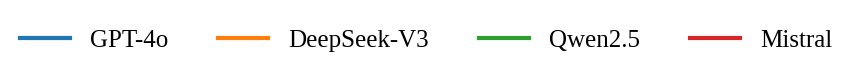

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D  

# 创建图例元素（使用Line2D，设置线条样式）
legend_elements = [
    Line2D([0], [0], 
           color=model_colors[model], 
           lw=3,  # 线宽
           label=model)
    for model in model_colors
]

# 单独创建一个图例图形
plt.figure(figsize=(10, 0.8))  # 调整宽度和高度
plt.axis('off')  # 关闭坐标轴

# 绘制图例（横向排列）
legend = plt.legend(
    handles=legend_elements,
    loc='center',
    ncol=4,  # 4列（横向排列）
    frameon=False,
    fontsize=18
)

In [3]:
from scipy.stats import ttest_rel, wilcoxon

# 每个 case 的 total 值
# pure_totals = [12, 11, 11, 15]
# multi_totals = [15, 17, 9, 18]
pure_totals = [3,2,4,3, 4,2,3,2, 2,2,4,3, 4,4,4,3]
multi_totals = [4,4,3,4, 4,3,5,5, 2,2,2,3, 5,5,5,3]

# 配对 t 检验
t_stat, p_val_t = ttest_rel(multi_totals, pure_totals)

# Wilcoxon signed-rank test（非参数）
w_stat, p_val_w = wilcoxon(multi_totals, pure_totals)

print(f"Paired t-test: p = {p_val_t:.4f}")
print(f"Wilcoxon test: p = {p_val_w:.4f}")


Paired t-test: p = 0.0555
Wilcoxon test: p = 0.0667


In [4]:
import numpy as np

diff = np.array(multi_totals) - np.array(pure_totals)
cohen_d = diff.mean() / diff.std(ddof=1)
print(f"Cohen's d = {cohen_d:.2f}")


Cohen's d = 0.52
